## Conditional Image Synthesis with Auxiliary Classifier GANs

## Architecture

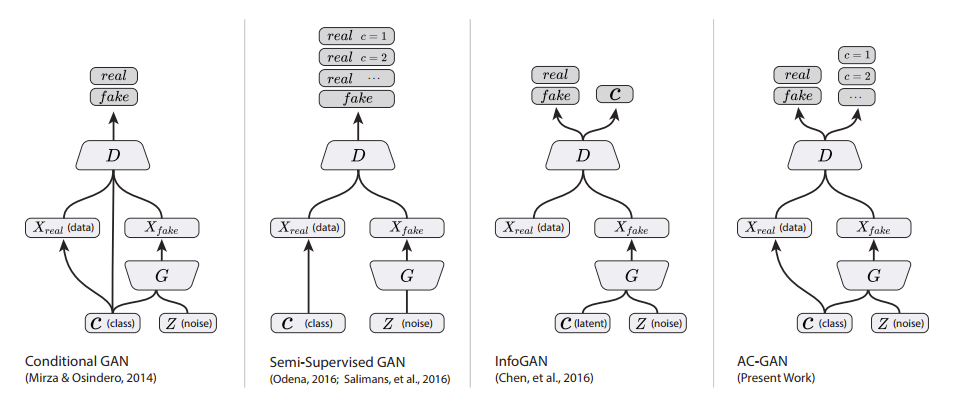

## Implementation

### Import libraries

In [55]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import numpy as np
import matplotlib.pyplot as plt

### Generator

In [56]:
# input1 noise 100 dimension
# input2 img category 10 dimension
# output 28*28*1

def build_generator(noise_dim, num_classes, con_dim):
    noise_input = layers.Input(shape=(noise_dim,))
    class_input = layers.Input(shape=(num_classes,))
    con_input = layers.Input(shape=(con_dim,))
    
    x = layers.Concatenate()([noise_input, class_input, con_input])
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dense(28 * 28 * 1, activation='tanh')(x)
    x = layers.Reshape((28, 28, 1))(x)
    
    return Model([noise_input, class_input, con_input], x)

### Discriminator

In [57]:
# input1 28*28*1
# input2 10
# output1 probability for real img
# output2 img label 
# output3 probability for continuous loss

def build_discriminator(img_shape, num_classes, con_dim):
    img_input = layers.Input(shape=img_shape)
    
    x = layers.Flatten()(img_input)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dense(256, activation='relu')(x)
    
    validity = layers.Dense(1, activation='sigmoid')(x)
    label = layers.Dense(num_classes, activation='softmax')(x)
    con = layers.Dense(con_dim, activation='sigmoid')(x)
    
    return Model(img_input, [validity, label, con])

### Build Model

In [58]:
img_shape = (28, 28, 1)
noise_dim = 100
num_classes = 10 # total categorical factor
con_dim = 2  # total continuous factor

generator = build_generator(noise_dim, num_classes, con_dim)
discriminator = build_discriminator(img_shape, num_classes, con_dim)

discriminator.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy', 'mse'], 
                      optimizer=tf.keras.optimizers.Adam(0.0002, 0.5),
                      metrics=['accuracy'])

noise = layers.Input(shape=(noise_dim,))
label = layers.Input(shape=(num_classes,))
con = layers.Input(shape=(con_dim,))
img = generator([noise, label, con])

# We only train the generator in the combined model
discriminator.trainable = False

# The discriminator's prediction for the generated image
valid, target_label, target_con = discriminator(img)

# Create the combined model
combined = Model([noise, label, con], [valid, target_label, target_con])

# Compile the combined model with appropriate losses
combined.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy', 'mse'],
                 optimizer=tf.keras.optimizers.Adam(0.0002, 0.5))

### Train

In [59]:
def train(epochs, batch_size=128, sample_interval=50):
    (X_train, y_train), (_, _) = tf.keras.datasets.mnist.load_data()
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5
    X_train = np.expand_dims(X_train, axis=3)
    y_train = y_train.reshape(-1, 1)

    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):
        # ---------------------
        #  Train Discriminator
        # ---------------------

        # Select a random batch of real images
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs, labels = X_train[idx], y_train[idx]

        # Generate a batch of new images
        noise = np.random.normal(0, 1, (batch_size, noise_dim))
        sampled_labels = np.random.randint(0, num_classes, (batch_size, 1))
        sampled_labels = tf.keras.utils.to_categorical(sampled_labels, num_classes)
        sampled_con = np.random.uniform(-1, 1, (batch_size, con_dim))

        gen_imgs = generator.predict([noise, sampled_labels, sampled_con])

        # Train the discriminator
        d_loss_real = discriminator.train_on_batch(imgs, [valid, labels, sampled_con])
        d_loss_fake = discriminator.train_on_batch(gen_imgs, [fake, sampled_labels.argmax(axis=1), sampled_con])

        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train Generator
        # ---------------------

        noise = np.random.normal(0, 1, (batch_size, noise_dim))
        sampled_labels = np.random.randint(0, num_classes, (batch_size, 1))
        sampled_labels = tf.keras.utils.to_categorical(sampled_labels, num_classes)
        sampled_con = np.random.uniform(-1, 1, (batch_size, con_dim))

        # Train the generator (to have the discriminator label samples as valid)
        g_loss = combined.train_on_batch([noise, sampled_labels, sampled_con], [valid, sampled_labels.argmax(axis=1), sampled_con])

        print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100*d_loss[3]}%] [G loss: {g_loss[0]}]")

        # If at save interval, save generated image samples
        if epoch % sample_interval == 0:
            sample_images(epoch)

def sample_images(epoch):
    r, c = 10, 10
    noise = np.random.normal(0, 1, (r * c, noise_dim))
    sampled_labels = np.tile(np.arange(0, 10), r)
    sampled_labels = tf.keras.utils.to_categorical(sampled_labels, num_classes)
    sampled_con = np.random.uniform(-1, 1, (r * c, con_dim))

    gen_imgs = generator.predict([noise, sampled_labels, sampled_con])

    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    plt.show()



1/1 [==============================] - 0s 26ms/step
0 [D loss: 4.166168689727783, acc.: 50.31523406505585%] [G loss: 3.6318795680999756]
4/4 [==============================] - 0s 3ms/step


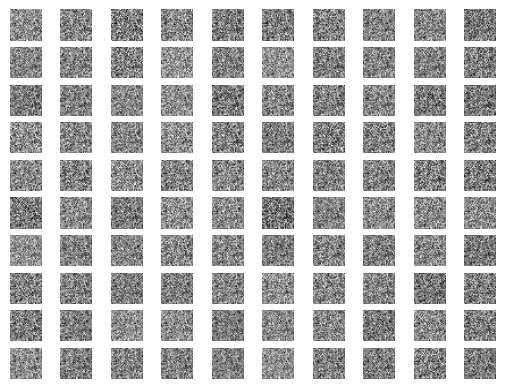

1/1 [==============================] - 0s 9ms/step
1 [D loss: 3.6881818771362305, acc.: 62.79386281967163%] [G loss: 3.5208051204681396]
1/1 [==============================] - 0s 9ms/step
2 [D loss: 3.319496989250183, acc.: 42.120809853076935%] [G loss: 3.3046321868896484]
1/1 [==============================] - 0s 9ms/step
3 [D loss: 3.357791304588318, acc.: 39.48947191238403%] [G loss: 3.3257155418395996]
1/1 [==============================] - 0s 10ms/step
4 [D loss: 3.188644051551819, acc.: 42.88226664066315%] [G loss: 3.2244551181793213]
1/1 [==============================] - 0s 9ms/step
5 [D loss: 3.217130661010742, acc.: 39.26742821931839%] [G loss: 3.1731579303741455]
1/1 [==============================] - 0s 8ms/step
6 [D loss: 3.0749990940093994, acc.: 31.4206063747406%] [G loss: 3.2746734619140625]
1/1 [==============================] - 0s 9ms/step
7 [D loss: 3.21512234210968, acc.: 42.20808446407318%] [G loss: 3.141947031021118]
1/1 [==============================] - 0s 8ms/s

1/1 [==============================] - 0s 9ms/step
61 [D loss: 2.5099836587905884, acc.: 35.956864058971405%] [G loss: 3.5895943641662598]
1/1 [==============================] - 0s 8ms/step
62 [D loss: 2.3499757051467896, acc.: 38.073866069316864%] [G loss: 3.705782413482666]
1/1 [==============================] - 0s 9ms/step
63 [D loss: 2.4989408254623413, acc.: 37.69459426403046%] [G loss: 3.7366762161254883]
1/1 [==============================] - 0s 8ms/step
64 [D loss: 2.3227742314338684, acc.: 35.40826290845871%] [G loss: 3.788229465484619]
1/1 [==============================] - 0s 11ms/step
65 [D loss: 2.3980953693389893, acc.: 33.74912738800049%] [G loss: 3.616325855255127]
1/1 [==============================] - 0s 9ms/step
66 [D loss: 2.4731849431991577, acc.: 29.395824670791626%] [G loss: 3.657078742980957]
1/1 [==============================] - 0s 8ms/step
67 [D loss: 2.293872833251953, acc.: 33.56500416994095%] [G loss: 3.8417162895202637]
1/1 [==============================

1/1 [==============================] - 0s 9ms/step
179 [D loss: 2.1911410093307495, acc.: 33.880482614040375%] [G loss: 3.615150213241577]
1/1 [==============================] - 0s 8ms/step
180 [D loss: 2.12591814994812, acc.: 34.12662297487259%] [G loss: 3.718074321746826]
1/1 [==============================] - 0s 9ms/step
181 [D loss: 2.2034271359443665, acc.: 31.73254132270813%] [G loss: 3.4833450317382812]
1/1 [==============================] - 0s 8ms/step
182 [D loss: 2.2124834060668945, acc.: 34.92930829524994%] [G loss: 3.6932871341705322]
1/1 [==============================] - 0s 9ms/step
183 [D loss: 2.1581660509109497, acc.: 39.53978419303894%] [G loss: 3.6203808784484863]
1/1 [==============================] - 0s 9ms/step
184 [D loss: 1.9706440567970276, acc.: 28.17111313343048%] [G loss: 3.732365608215332]
1/1 [==============================] - 0s 9ms/step
185 [D loss: 2.08611136674881, acc.: 30.66931664943695%] [G loss: 3.638333797454834]
1/1 [=============================

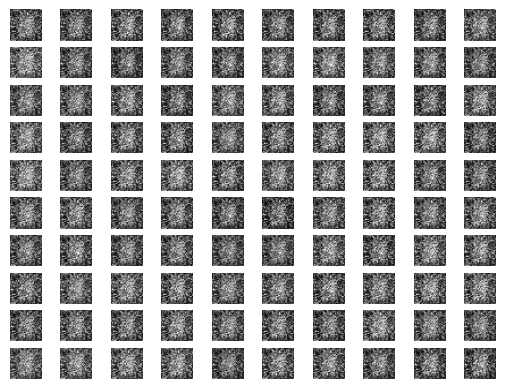

1/1 [==============================] - 0s 9ms/step
201 [D loss: 2.016118347644806, acc.: 34.02013182640076%] [G loss: 3.6376914978027344]
1/1 [==============================] - 0s 10ms/step
202 [D loss: 2.187983989715576, acc.: 31.155890226364136%] [G loss: 3.45430850982666]
1/1 [==============================] - 0s 8ms/step
203 [D loss: 2.158030152320862, acc.: 32.65805393457413%] [G loss: 3.6047868728637695]
1/1 [==============================] - 0s 8ms/step
204 [D loss: 2.310422897338867, acc.: 31.840692460536957%] [G loss: 3.598546028137207]
1/1 [==============================] - 0s 9ms/step
205 [D loss: 2.1836941838264465, acc.: 39.364905655384064%] [G loss: 3.738062620162964]
1/1 [==============================] - 0s 8ms/step
206 [D loss: 2.2288050651550293, acc.: 42.16141998767853%] [G loss: 3.9244585037231445]
1/1 [==============================] - 0s 8ms/step
207 [D loss: 2.1799712777137756, acc.: 36.6108164191246%] [G loss: 3.682375907897949]
1/1 [============================

1/1 [==============================] - 0s 9ms/step
319 [D loss: 1.713748812675476, acc.: 29.608599841594696%] [G loss: 2.524892568588257]
1/1 [==============================] - 0s 8ms/step
320 [D loss: 1.708259403705597, acc.: 32.15358108282089%] [G loss: 2.6310296058654785]
1/1 [==============================] - 0s 18ms/step
321 [D loss: 1.7810223698616028, acc.: 34.60797220468521%] [G loss: 2.7055983543395996]
1/1 [==============================] - 0s 10ms/step
322 [D loss: 1.6480520367622375, acc.: 34.18239653110504%] [G loss: 2.632105827331543]
1/1 [==============================] - 0s 10ms/step
323 [D loss: 1.7202529907226562, acc.: 32.50446021556854%] [G loss: 2.664301872253418]
1/1 [==============================] - 0s 9ms/step
324 [D loss: 1.4757140278816223, acc.: 30.74699193239212%] [G loss: 2.4939677715301514]
1/1 [==============================] - 0s 9ms/step
325 [D loss: 1.8037471771240234, acc.: 29.90046590566635%] [G loss: 2.7497506141662598]
1/1 [=======================

1/1 [==============================] - 0s 9ms/step
378 [D loss: 1.3942998051643372, acc.: 39.898478984832764%] [G loss: 2.3810842037200928]
1/1 [==============================] - 0s 9ms/step
379 [D loss: 1.3895116448402405, acc.: 26.347272098064423%] [G loss: 2.419020891189575]
1/1 [==============================] - 0s 10ms/step
380 [D loss: 1.4434275031089783, acc.: 36.02369576692581%] [G loss: 2.3906986713409424]
1/1 [==============================] - 0s 8ms/step
381 [D loss: 1.4971743822097778, acc.: 30.52400052547455%] [G loss: 2.2447030544281006]
1/1 [==============================] - 0s 8ms/step
382 [D loss: 1.4804966449737549, acc.: 37.20249533653259%] [G loss: 2.270110607147217]
1/1 [==============================] - 0s 11ms/step
383 [D loss: 1.546876072883606, acc.: 27.841174602508545%] [G loss: 2.4345171451568604]
1/1 [==============================] - 0s 8ms/step
384 [D loss: 1.4381933808326721, acc.: 28.761494159698486%] [G loss: 2.21785831451416]
1/1 [=====================

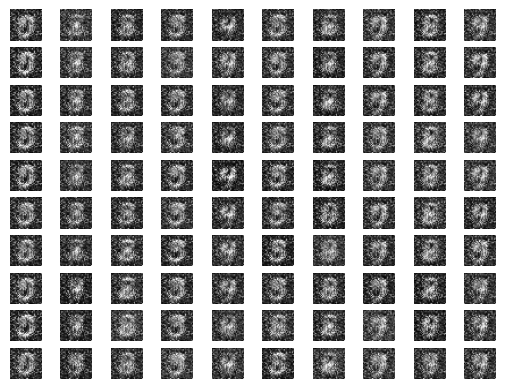

1/1 [==============================] - 0s 9ms/step
401 [D loss: 1.6600258350372314, acc.: 32.507649064064026%] [G loss: 1.7791849374771118]
1/1 [==============================] - 0s 9ms/step
402 [D loss: 1.5419005751609802, acc.: 35.35502701997757%] [G loss: 2.2596664428710938]
1/1 [==============================] - 0s 10ms/step
403 [D loss: 1.6591269969940186, acc.: 33.860333263874054%] [G loss: 2.2932426929473877]
1/1 [==============================] - 0s 10ms/step
404 [D loss: 1.363889992237091, acc.: 34.46207195520401%] [G loss: 2.079932451248169]
1/1 [==============================] - 0s 8ms/step
405 [D loss: 1.2463071942329407, acc.: 33.4538534283638%] [G loss: 2.3968429565429688]
1/1 [==============================] - 0s 8ms/step
406 [D loss: 1.4632796049118042, acc.: 33.31482112407684%] [G loss: 2.191378355026245]
1/1 [==============================] - 0s 9ms/step
407 [D loss: 1.3121509552001953, acc.: 38.87549340724945%] [G loss: 2.3950014114379883]
1/1 [======================

1/1 [==============================] - 0s 8ms/step
519 [D loss: 1.246110200881958, acc.: 40.5035138130188%] [G loss: 1.8494468927383423]
1/1 [==============================] - 0s 8ms/step
520 [D loss: 1.2440597414970398, acc.: 31.302759051322937%] [G loss: 2.0209858417510986]
1/1 [==============================] - 0s 8ms/step
521 [D loss: 1.2846122980117798, acc.: 27.784758806228638%] [G loss: 1.6845078468322754]
1/1 [==============================] - 0s 8ms/step
522 [D loss: 1.6009527444839478, acc.: 37.95301765203476%] [G loss: 1.6358448266983032]
1/1 [==============================] - 0s 8ms/step
523 [D loss: 1.370547890663147, acc.: 30.21257072687149%] [G loss: 1.581705093383789]
1/1 [==============================] - 0s 8ms/step
524 [D loss: 1.1952094435691833, acc.: 30.668798089027405%] [G loss: 1.8641180992126465]
1/1 [==============================] - 0s 8ms/step
525 [D loss: 1.4981409311294556, acc.: 37.17539608478546%] [G loss: 1.6985522508621216]
1/1 [=======================

1/1 [==============================] - 0s 8ms/step
578 [D loss: 1.190105676651001, acc.: 35.67166328430176%] [G loss: 1.7437560558319092]
1/1 [==============================] - 0s 8ms/step
579 [D loss: 1.0300233364105225, acc.: 29.29644286632538%] [G loss: 1.7023863792419434]
1/1 [==============================] - 0s 9ms/step
580 [D loss: 1.1361847519874573, acc.: 30.95705956220627%] [G loss: 1.778374433517456]
1/1 [==============================] - 0s 9ms/step
581 [D loss: 1.1806131601333618, acc.: 33.23666751384735%] [G loss: 1.8576295375823975]
1/1 [==============================] - 0s 8ms/step
582 [D loss: 1.1006954312324524, acc.: 28.708845376968384%] [G loss: 1.9847071170806885]
1/1 [==============================] - 0s 9ms/step
583 [D loss: 1.089690387248993, acc.: 34.37776565551758%] [G loss: 1.8349318504333496]
1/1 [==============================] - 0s 9ms/step
584 [D loss: 1.045526146888733, acc.: 32.663723826408386%] [G loss: 1.831373691558838]
1/1 [=========================

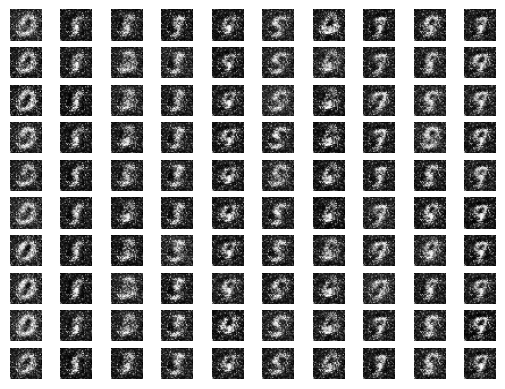

1/1 [==============================] - 0s 8ms/step
601 [D loss: 1.4052573442459106, acc.: 34.191013872623444%] [G loss: 1.5913784503936768]
1/1 [==============================] - 0s 8ms/step
602 [D loss: 1.2528384923934937, acc.: 31.700727343559265%] [G loss: 1.874452829360962]
1/1 [==============================] - 0s 8ms/step
603 [D loss: 1.1513398885726929, acc.: 30.60171902179718%] [G loss: 1.8842777013778687]
1/1 [==============================] - 0s 8ms/step
604 [D loss: 1.1911606788635254, acc.: 31.267176568508148%] [G loss: 1.6809942722320557]
1/1 [==============================] - 0s 8ms/step
605 [D loss: 1.1835212707519531, acc.: 34.295493364334106%] [G loss: 1.8793070316314697]
1/1 [==============================] - 0s 8ms/step
606 [D loss: 1.1122223734855652, acc.: 41.83511435985565%] [G loss: 2.0449094772338867]
1/1 [==============================] - 0s 9ms/step
607 [D loss: 1.034372329711914, acc.: 33.12337100505829%] [G loss: 1.9157886505126953]
1/1 [====================

1/1 [==============================] - 0s 11ms/step
660 [D loss: 1.12562096118927, acc.: 36.59591227769852%] [G loss: 1.7234009504318237]
1/1 [==============================] - 0s 10ms/step
661 [D loss: 1.1782322525978088, acc.: 43.530528247356415%] [G loss: 1.9664616584777832]
1/1 [==============================] - 0s 9ms/step
662 [D loss: 1.2565284967422485, acc.: 38.737815618515015%] [G loss: 1.702434778213501]
1/1 [==============================] - 0s 8ms/step
663 [D loss: 1.0750701427459717, acc.: 33.00575762987137%] [G loss: 1.7280120849609375]
1/1 [==============================] - 0s 8ms/step
664 [D loss: 1.3799273371696472, acc.: 33.83960723876953%] [G loss: 1.4868230819702148]
1/1 [==============================] - 0s 10ms/step
665 [D loss: 1.1302695274353027, acc.: 29.650190472602844%] [G loss: 1.8178237676620483]
1/1 [==============================] - 0s 9ms/step
666 [D loss: 1.0639750361442566, acc.: 30.675126612186432%] [G loss: 1.7019511461257935]
1/1 [==================

1/1 [==============================] - 0s 10ms/step
719 [D loss: 0.8617326319217682, acc.: 27.761220932006836%] [G loss: 1.8571056127548218]
1/1 [==============================] - 0s 8ms/step
720 [D loss: 0.9600726366043091, acc.: 34.32830572128296%] [G loss: 1.8721623420715332]
1/1 [==============================] - 0s 9ms/step
721 [D loss: 0.8578856289386749, acc.: 30.159276723861694%] [G loss: 2.025648355484009]
1/1 [==============================] - 0s 8ms/step
722 [D loss: 0.9319791793823242, acc.: 30.937035381793976%] [G loss: 1.988978624343872]
1/1 [==============================] - 0s 9ms/step
723 [D loss: 0.9916796386241913, acc.: 31.18777573108673%] [G loss: 1.9053499698638916]
1/1 [==============================] - 0s 8ms/step
724 [D loss: 0.8162132501602173, acc.: 39.75125253200531%] [G loss: 2.0203676223754883]
1/1 [==============================] - 0s 9ms/step
725 [D loss: 1.1452787518501282, acc.: 32.03160911798477%] [G loss: 2.0330023765563965]
1/1 [====================

1/1 [==============================] - 0s 10ms/step
778 [D loss: 1.0308992862701416, acc.: 26.34924352169037%] [G loss: 1.8034288883209229]
1/1 [==============================] - 0s 8ms/step
779 [D loss: 1.1749601364135742, acc.: 41.838738322257996%] [G loss: 1.7091838121414185]
1/1 [==============================] - 0s 9ms/step
780 [D loss: 1.1783767342567444, acc.: 33.37375819683075%] [G loss: 1.5677452087402344]
1/1 [==============================] - 0s 11ms/step
781 [D loss: 1.093748390674591, acc.: 34.44155156612396%] [G loss: 1.8698316812515259]
1/1 [==============================] - 0s 9ms/step
782 [D loss: 0.9951171875, acc.: 34.655068814754486%] [G loss: 1.7787950038909912]
1/1 [==============================] - 0s 9ms/step
783 [D loss: 1.0562013387680054, acc.: 29.11631315946579%] [G loss: 1.8503696918487549]
1/1 [==============================] - 0s 8ms/step
784 [D loss: 0.9467041492462158, acc.: 34.17065441608429%] [G loss: 1.658706545829773]
1/1 [==========================

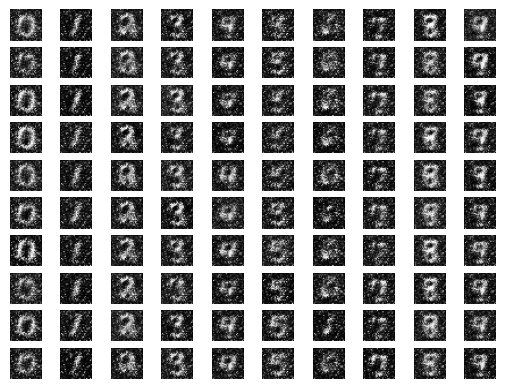

1/1 [==============================] - 0s 10ms/step
801 [D loss: 1.0671149492263794, acc.: 34.53369140625%] [G loss: 1.6557403802871704]
1/1 [==============================] - 0s 9ms/step
802 [D loss: 0.980311781167984, acc.: 34.48833078145981%] [G loss: 1.746023416519165]
1/1 [==============================] - 0s 10ms/step
803 [D loss: 1.0893968343734741, acc.: 32.9000785946846%] [G loss: 1.9188450574874878]
1/1 [==============================] - 0s 8ms/step
804 [D loss: 1.3003953099250793, acc.: 50.41846036911011%] [G loss: 1.793355941772461]
1/1 [==============================] - 0s 9ms/step
805 [D loss: 0.9285816252231598, acc.: 29.285171627998352%] [G loss: 1.7715920209884644]
1/1 [==============================] - 0s 8ms/step
806 [D loss: 1.0810238122940063, acc.: 31.844021379947662%] [G loss: 1.8788375854492188]
1/1 [==============================] - 0s 10ms/step
807 [D loss: 0.9877885580062866, acc.: 35.454364120960236%] [G loss: 1.9678629636764526]
1/1 [=======================

1/1 [==============================] - 0s 8ms/step
860 [D loss: 1.1304048895835876, acc.: 41.70186370611191%] [G loss: 1.7167094945907593]
1/1 [==============================] - 0s 9ms/step
861 [D loss: 1.030163288116455, acc.: 32.650554180145264%] [G loss: 1.551883578300476]
1/1 [==============================] - 0s 9ms/step
862 [D loss: 1.0462271571159363, acc.: 41.546544432640076%] [G loss: 1.6642428636550903]
1/1 [==============================] - 0s 9ms/step
863 [D loss: 1.110762357711792, acc.: 35.61063855886459%] [G loss: 1.6714870929718018]
1/1 [==============================] - 0s 9ms/step
864 [D loss: 1.0878756642341614, acc.: 30.810216069221497%] [G loss: 1.8337287902832031]
1/1 [==============================] - 0s 8ms/step
865 [D loss: 1.1380272209644318, acc.: 33.27990174293518%] [G loss: 1.743068814277649]
1/1 [==============================] - 0s 9ms/step
866 [D loss: 0.9938006103038788, acc.: 34.97052788734436%] [G loss: 1.7613919973373413]
1/1 [=======================

1/1 [==============================] - 0s 9ms/step
919 [D loss: 0.9380795061588287, acc.: 30.5934339761734%] [G loss: 2.1159827709198]
1/1 [==============================] - 0s 9ms/step
920 [D loss: 1.0067032873630524, acc.: 30.62444031238556%] [G loss: 1.8686484098434448]
1/1 [==============================] - 0s 9ms/step
921 [D loss: 1.1310376524925232, acc.: 34.873177111148834%] [G loss: 1.8487532138824463]
1/1 [==============================] - 0s 9ms/step
922 [D loss: 0.8410699963569641, acc.: 27.543629705905914%] [G loss: 2.374411106109619]
1/1 [==============================] - 0s 8ms/step
923 [D loss: 1.262176513671875, acc.: 38.65802884101868%] [G loss: 2.397385597229004]
1/1 [==============================] - 0s 9ms/step
924 [D loss: 1.2007297277450562, acc.: 33.22917819023132%] [G loss: 1.7430018186569214]
1/1 [==============================] - 0s 8ms/step
925 [D loss: 1.1113795042037964, acc.: 30.54848611354828%] [G loss: 2.0836875438690186]
1/1 [===========================

1/1 [==============================] - 0s 9ms/step
978 [D loss: 1.009303331375122, acc.: 31.496457755565643%] [G loss: 1.5808148384094238]
1/1 [==============================] - 0s 8ms/step
979 [D loss: 1.0104079246520996, acc.: 30.86208552122116%] [G loss: 1.7050082683563232]
1/1 [==============================] - 0s 8ms/step
980 [D loss: 1.1775904297828674, acc.: 36.58154755830765%] [G loss: 1.9386016130447388]
1/1 [==============================] - 0s 8ms/step
981 [D loss: 1.0606135725975037, acc.: 26.733650267124176%] [G loss: 1.7032532691955566]
1/1 [==============================] - 0s 9ms/step
982 [D loss: 1.1563090682029724, acc.: 30.990394949913025%] [G loss: 1.657692313194275]
1/1 [==============================] - 0s 8ms/step
983 [D loss: 1.236088216304779, acc.: 33.7067186832428%] [G loss: 1.3879685401916504]
1/1 [==============================] - 0s 10ms/step
984 [D loss: 1.1818122863769531, acc.: 33.04014950990677%] [G loss: 1.5546603202819824]
1/1 [======================

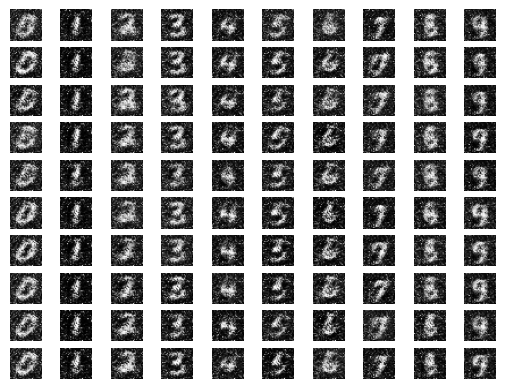

1/1 [==============================] - 0s 9ms/step
1001 [D loss: 0.9640988111495972, acc.: 23.381825536489487%] [G loss: 1.8266255855560303]
1/1 [==============================] - 0s 8ms/step
1002 [D loss: 0.9394374787807465, acc.: 33.48686248064041%] [G loss: 2.060926914215088]
1/1 [==============================] - 0s 8ms/step
1003 [D loss: 1.107225775718689, acc.: 37.203919887542725%] [G loss: 1.676226019859314]
1/1 [==============================] - 0s 9ms/step
1004 [D loss: 1.5115726590156555, acc.: 40.31831920146942%] [G loss: 1.6379344463348389]
1/1 [==============================] - 0s 9ms/step
1005 [D loss: 0.9520908296108246, acc.: 33.345384895801544%] [G loss: 2.0560302734375]
1/1 [==============================] - 0s 9ms/step
1006 [D loss: 1.12782883644104, acc.: 36.38477027416229%] [G loss: 1.7810416221618652]
1/1 [==============================] - 0s 8ms/step
1007 [D loss: 1.2411107420921326, acc.: 36.24761700630188%] [G loss: 1.6173954010009766]
1/1 [====================

1/1 [==============================] - 0s 8ms/step
1060 [D loss: 1.0338454842567444, acc.: 35.84439158439636%] [G loss: 1.6627843379974365]
1/1 [==============================] - 0s 8ms/step
1061 [D loss: 1.2350786924362183, acc.: 30.660198628902435%] [G loss: 1.4386321306228638]
1/1 [==============================] - 0s 8ms/step
1062 [D loss: 1.1192769408226013, acc.: 34.60668474435806%] [G loss: 1.4476597309112549]
1/1 [==============================] - 0s 11ms/step
1063 [D loss: 0.93116295337677, acc.: 30.536210536956787%] [G loss: 1.5977892875671387]
1/1 [==============================] - 0s 8ms/step
1064 [D loss: 1.066567212343216, acc.: 31.38628602027893%] [G loss: 1.6814873218536377]
1/1 [==============================] - 0s 10ms/step
1065 [D loss: 0.989877313375473, acc.: 36.18261367082596%] [G loss: 1.550349235534668]
1/1 [==============================] - 0s 10ms/step
1066 [D loss: 1.042431116104126, acc.: 28.575734794139862%] [G loss: 1.7776917219161987]
1/1 [===============

1/1 [==============================] - 0s 9ms/step
1119 [D loss: 1.159878522157669, acc.: 29.26175594329834%] [G loss: 1.6562473773956299]
1/1 [==============================] - 0s 8ms/step
1120 [D loss: 0.894106537103653, acc.: 34.54331457614899%] [G loss: 1.709010124206543]
1/1 [==============================] - 0s 9ms/step
1121 [D loss: 1.1997489929199219, acc.: 33.87700468301773%] [G loss: 1.8060669898986816]
1/1 [==============================] - 0s 8ms/step
1122 [D loss: 1.1825803518295288, acc.: 33.571770787239075%] [G loss: 1.8641679286956787]
1/1 [==============================] - 0s 8ms/step
1123 [D loss: 0.9374333620071411, acc.: 31.108389794826508%] [G loss: 2.0658130645751953]
1/1 [==============================] - 0s 9ms/step
1124 [D loss: 1.200839877128601, acc.: 25.26472508907318%] [G loss: 2.0357587337493896]
1/1 [==============================] - 0s 10ms/step
1125 [D loss: 1.1215257048606873, acc.: 29.615098237991333%] [G loss: 1.8741986751556396]
1/1 [===============

1/1 [==============================] - 0s 9ms/step
1178 [D loss: 0.9830595254898071, acc.: 34.598878026008606%] [G loss: 1.760676383972168]
1/1 [==============================] - 0s 8ms/step
1179 [D loss: 1.0330218970775604, acc.: 27.197234332561493%] [G loss: 1.7839266061782837]
1/1 [==============================] - 0s 9ms/step
1180 [D loss: 0.9211876392364502, acc.: 29.237280786037445%] [G loss: 1.7134506702423096]
1/1 [==============================] - 0s 9ms/step
1181 [D loss: 1.025687038898468, acc.: 36.19536608457565%] [G loss: 1.8543479442596436]
1/1 [==============================] - 0s 8ms/step
1182 [D loss: 0.9479750394821167, acc.: 29.462796449661255%] [G loss: 1.6492998600006104]
1/1 [==============================] - 0s 10ms/step
1183 [D loss: 1.2030889391899109, acc.: 32.12485909461975%] [G loss: 1.7256157398223877]
1/1 [==============================] - 0s 9ms/step
1184 [D loss: 1.0221970677375793, acc.: 31.212759017944336%] [G loss: 1.907212734222412]
1/1 [============

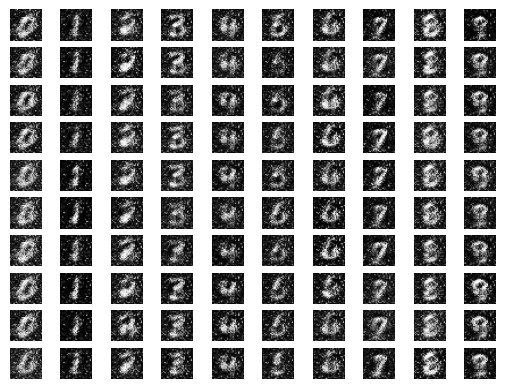

1/1 [==============================] - 0s 10ms/step
1201 [D loss: 1.1416940689086914, acc.: 31.893575191497803%] [G loss: 1.7096354961395264]
1/1 [==============================] - 0s 8ms/step
1202 [D loss: 1.0186322331428528, acc.: 35.033708810806274%] [G loss: 1.7594918012619019]
1/1 [==============================] - 0s 10ms/step
1203 [D loss: 0.9201924502849579, acc.: 35.85016578435898%] [G loss: 2.0334150791168213]
1/1 [==============================] - 0s 10ms/step
1204 [D loss: 0.8807313740253448, acc.: 31.168395280838013%] [G loss: 1.9772194623947144]
1/1 [==============================] - 0s 8ms/step
1205 [D loss: 1.0028989017009735, acc.: 28.94706428050995%] [G loss: 2.1126110553741455]
1/1 [==============================] - 0s 11ms/step
1206 [D loss: 1.0597390532493591, acc.: 36.48461997509003%] [G loss: 1.8606212139129639]
1/1 [==============================] - 0s 9ms/step
1207 [D loss: 1.2086777687072754, acc.: 37.58050203323364%] [G loss: 1.7674169540405273]
1/1 [========

1/1 [==============================] - 0s 9ms/step
1260 [D loss: 0.9584158360958099, acc.: 32.21358358860016%] [G loss: 2.0169880390167236]
1/1 [==============================] - 0s 9ms/step
1261 [D loss: 1.0661777257919312, acc.: 37.520989775657654%] [G loss: 1.843194842338562]
1/1 [==============================] - 0s 10ms/step
1262 [D loss: 0.9644622504711151, acc.: 27.519044280052185%] [G loss: 1.8788303136825562]
1/1 [==============================] - 0s 9ms/step
1263 [D loss: 0.8742777407169342, acc.: 34.354548156261444%] [G loss: 1.9876842498779297]
1/1 [==============================] - 0s 8ms/step
1264 [D loss: 1.164201259613037, acc.: 39.857856929302216%] [G loss: 1.8188008069992065]
1/1 [==============================] - 0s 9ms/step
1265 [D loss: 1.2165590524673462, acc.: 38.03347051143646%] [G loss: 1.8253809213638306]
1/1 [==============================] - 0s 11ms/step
1266 [D loss: 1.3557978868484497, acc.: 35.766178369522095%] [G loss: 1.508176326751709]
1/1 [===========

1/1 [==============================] - 0s 8ms/step
1319 [D loss: 0.9953846335411072, acc.: 33.294178545475006%] [G loss: 1.7444078922271729]
1/1 [==============================] - 0s 9ms/step
1320 [D loss: 0.9110415577888489, acc.: 28.61540913581848%] [G loss: 1.8686188459396362]
1/1 [==============================] - 0s 9ms/step
1321 [D loss: 1.0996919870376587, acc.: 31.554074585437775%] [G loss: 1.8949228525161743]
1/1 [==============================] - 0s 9ms/step
1322 [D loss: 1.0416409075260162, acc.: 33.882078528404236%] [G loss: 1.9433841705322266]
1/1 [==============================] - 0s 9ms/step
1323 [D loss: 0.9585090577602386, acc.: 29.32760864496231%] [G loss: 1.7473398447036743]
1/1 [==============================] - 0s 10ms/step
1324 [D loss: 1.0594884753227234, acc.: 37.213462591171265%] [G loss: 1.8596808910369873]
1/1 [==============================] - 0s 9ms/step
1325 [D loss: 0.9775100946426392, acc.: 34.08905863761902%] [G loss: 1.9114749431610107]
1/1 [==========

1/1 [==============================] - 0s 8ms/step
1378 [D loss: 0.9432194530963898, acc.: 34.71802622079849%] [G loss: 2.3961331844329834]
1/1 [==============================] - 0s 9ms/step
1379 [D loss: 1.0462190508842468, acc.: 31.213170289993286%] [G loss: 2.240539312362671]
1/1 [==============================] - 0s 8ms/step
1380 [D loss: 1.001422107219696, acc.: 31.68008029460907%] [G loss: 2.027024745941162]
1/1 [==============================] - 0s 8ms/step
1381 [D loss: 0.9835615754127502, acc.: 34.62585210800171%] [G loss: 1.9573482275009155]
1/1 [==============================] - 0s 8ms/step
1382 [D loss: 1.1036784648895264, acc.: 35.8553946018219%] [G loss: 1.944006323814392]
1/1 [==============================] - 0s 8ms/step
1383 [D loss: 1.0461196303367615, acc.: 43.976230919361115%] [G loss: 2.1655471324920654]
1/1 [==============================] - 0s 10ms/step
1384 [D loss: 1.030655562877655, acc.: 35.8496218919754%] [G loss: 2.3427600860595703]
1/1 [===================

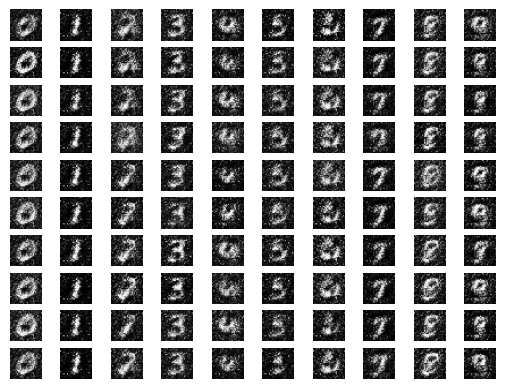

1/1 [==============================] - 0s 10ms/step
1401 [D loss: 1.0397523045539856, acc.: 34.77484434843063%] [G loss: 1.7339622974395752]
1/1 [==============================] - 0s 10ms/step
1402 [D loss: 0.9294662475585938, acc.: 29.83514964580536%] [G loss: 1.8553537130355835]
1/1 [==============================] - 0s 10ms/step
1403 [D loss: 1.011532485485077, acc.: 33.37774723768234%] [G loss: 1.8428152799606323]
1/1 [==============================] - 0s 8ms/step
1404 [D loss: 1.1734010577201843, acc.: 41.767363250255585%] [G loss: 1.6998560428619385]
1/1 [==============================] - 0s 10ms/step
1405 [D loss: 0.8598790168762207, acc.: 37.46071010828018%] [G loss: 1.7651923894882202]
1/1 [==============================] - 0s 9ms/step
1406 [D loss: 0.8797150552272797, acc.: 30.962152779102325%] [G loss: 1.7951711416244507]
1/1 [==============================] - 0s 8ms/step
1407 [D loss: 0.8976755142211914, acc.: 35.683976113796234%] [G loss: 1.745883584022522]
1/1 [==========

1/1 [==============================] - 0s 8ms/step
1460 [D loss: 1.0588468313217163, acc.: 41.23683273792267%] [G loss: 2.088498592376709]
1/1 [==============================] - 0s 9ms/step
1461 [D loss: 1.215654343366623, acc.: 36.30875051021576%] [G loss: 1.8945395946502686]
1/1 [==============================] - 0s 8ms/step
1462 [D loss: 0.9383023381233215, acc.: 28.26370596885681%] [G loss: 1.8647642135620117]
1/1 [==============================] - 0s 8ms/step
1463 [D loss: 0.9867005348205566, acc.: 29.08436506986618%] [G loss: 1.8564858436584473]
1/1 [==============================] - 0s 9ms/step
1464 [D loss: 1.018375277519226, acc.: 29.511938989162445%] [G loss: 2.007505178451538]
1/1 [==============================] - 0s 9ms/step
1465 [D loss: 1.0707785189151764, acc.: 29.899944365024567%] [G loss: 1.82132089138031]
1/1 [==============================] - 0s 8ms/step
1466 [D loss: 1.0250399112701416, acc.: 30.471934378147125%] [G loss: 1.763369083404541]
1/1 [===================

1/1 [==============================] - 0s 9ms/step
1519 [D loss: 1.3120329976081848, acc.: 37.28927671909332%] [G loss: 1.5355854034423828]
1/1 [==============================] - 0s 9ms/step
1520 [D loss: 0.8704690337181091, acc.: 33.67072939872742%] [G loss: 2.089850902557373]
1/1 [==============================] - 0s 8ms/step
1521 [D loss: 1.2764790654182434, acc.: 25.052808970212936%] [G loss: 1.5601357221603394]
1/1 [==============================] - 0s 8ms/step
1522 [D loss: 1.145003855228424, acc.: 34.050095081329346%] [G loss: 1.6743308305740356]
1/1 [==============================] - 0s 11ms/step
1523 [D loss: 1.1337984204292297, acc.: 36.65997087955475%] [G loss: 2.02668833732605]
1/1 [==============================] - 0s 9ms/step
1524 [D loss: 1.10762619972229, acc.: 30.594371259212494%] [G loss: 1.9008047580718994]
1/1 [==============================] - 0s 8ms/step
1525 [D loss: 0.9942669570446014, acc.: 28.103744983673096%] [G loss: 1.9422286748886108]
1/1 [================

1/1 [==============================] - 0s 8ms/step
1578 [D loss: 1.1345823407173157, acc.: 36.23772859573364%] [G loss: 1.5091257095336914]
1/1 [==============================] - 0s 8ms/step
1579 [D loss: 1.2037213444709778, acc.: 30.28305172920227%] [G loss: 1.4376118183135986]
1/1 [==============================] - 0s 8ms/step
1580 [D loss: 1.0645316243171692, acc.: 35.01201272010803%] [G loss: 1.7841709852218628]
1/1 [==============================] - 0s 8ms/step
1581 [D loss: 0.9916322529315948, acc.: 31.036171317100525%] [G loss: 1.808687448501587]
1/1 [==============================] - 0s 8ms/step
1582 [D loss: 1.2140752077102661, acc.: 32.83761143684387%] [G loss: 1.6938683986663818]
1/1 [==============================] - 0s 8ms/step
1583 [D loss: 1.0699757635593414, acc.: 36.35948300361633%] [G loss: 1.6967374086380005]
1/1 [==============================] - 0s 10ms/step
1584 [D loss: 1.0215380191802979, acc.: 37.443217635154724%] [G loss: 1.5269548892974854]
1/1 [=============

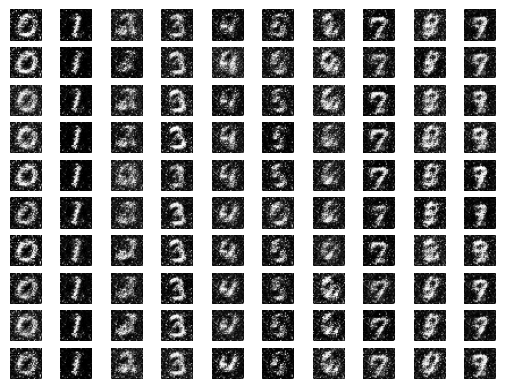

1/1 [==============================] - 0s 9ms/step
1601 [D loss: 0.9198152720928192, acc.: 29.92231696844101%] [G loss: 1.6845357418060303]
1/1 [==============================] - 0s 10ms/step
1602 [D loss: 0.8845582902431488, acc.: 31.9719061255455%] [G loss: 1.6945762634277344]
1/1 [==============================] - 0s 9ms/step
1603 [D loss: 0.994310587644577, acc.: 33.48788917064667%] [G loss: 1.772871494293213]
1/1 [==============================] - 0s 11ms/step
1604 [D loss: 0.9118485748767853, acc.: 35.97519248723984%] [G loss: 1.7199660539627075]
1/1 [==============================] - 0s 9ms/step
1605 [D loss: 0.9457034468650818, acc.: 30.85242509841919%] [G loss: 1.6605806350708008]
1/1 [==============================] - 0s 8ms/step
1606 [D loss: 1.2704135179519653, acc.: 37.63514161109924%] [G loss: 1.6703506708145142]
1/1 [==============================] - 0s 9ms/step
1607 [D loss: 0.920001357793808, acc.: 36.111555993556976%] [G loss: 1.6598200798034668]
1/1 [================

1/1 [==============================] - 0s 8ms/step
1660 [D loss: 0.9135724306106567, acc.: 38.14915865659714%] [G loss: 2.075967311859131]
1/1 [==============================] - 0s 9ms/step
1661 [D loss: 0.9016431570053101, acc.: 35.31618118286133%] [G loss: 2.212554931640625]
1/1 [==============================] - 0s 8ms/step
1662 [D loss: 0.8957255482673645, acc.: 34.20480936765671%] [G loss: 1.8549771308898926]
1/1 [==============================] - 0s 8ms/step
1663 [D loss: 0.9476391971111298, acc.: 33.239200711250305%] [G loss: 1.9420326948165894]
1/1 [==============================] - 0s 8ms/step
1664 [D loss: 0.9400172233581543, acc.: 38.75827044248581%] [G loss: 1.9461233615875244]
1/1 [==============================] - 0s 9ms/step
1665 [D loss: 0.9355204701423645, acc.: 34.84761118888855%] [G loss: 1.6735213994979858]
1/1 [==============================] - 0s 9ms/step
1666 [D loss: 0.8884861469268799, acc.: 35.94825267791748%] [G loss: 1.836031198501587]
1/1 [=================

1/1 [==============================] - 0s 9ms/step
1719 [D loss: 0.8006690740585327, acc.: 35.072529315948486%] [G loss: 2.142087936401367]
1/1 [==============================] - 0s 10ms/step
1720 [D loss: 1.017379879951477, acc.: 31.78381770849228%] [G loss: 1.878596305847168]
1/1 [==============================] - 0s 9ms/step
1721 [D loss: 0.9198682308197021, acc.: 32.79783874750137%] [G loss: 2.0157957077026367]
1/1 [==============================] - 0s 8ms/step
1722 [D loss: 0.8055448830127716, acc.: 32.17470496892929%] [G loss: 1.8842865228652954]
1/1 [==============================] - 0s 10ms/step
1723 [D loss: 0.7919661104679108, acc.: 26.991157233715057%] [G loss: 2.069387674331665]
1/1 [==============================] - 0s 9ms/step
1724 [D loss: 0.808676153421402, acc.: 23.66713657975197%] [G loss: 1.9525549411773682]
1/1 [==============================] - 0s 8ms/step
1725 [D loss: 1.0351426899433136, acc.: 34.122134745121%] [G loss: 1.9359773397445679]
1/1 [==================

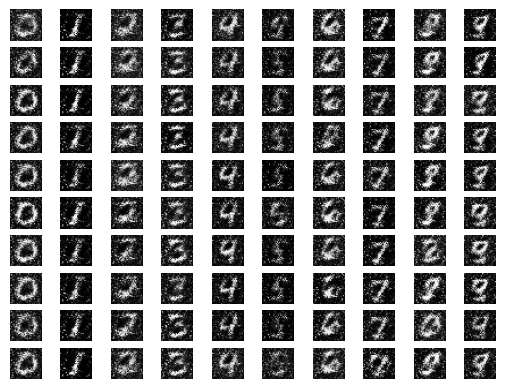

1/1 [==============================] - 0s 9ms/step
1801 [D loss: 1.042918175458908, acc.: 39.20110762119293%] [G loss: 1.9899849891662598]
1/1 [==============================] - 0s 9ms/step
1802 [D loss: 0.9942518174648285, acc.: 34.798216819763184%] [G loss: 2.0250048637390137]
1/1 [==============================] - 0s 8ms/step
1803 [D loss: 1.1752834618091583, acc.: 32.767701148986816%] [G loss: 2.067976951599121]
1/1 [==============================] - 0s 9ms/step
1804 [D loss: 1.0664387345314026, acc.: 31.46747499704361%] [G loss: 2.1425058841705322]
1/1 [==============================] - 0s 8ms/step
1805 [D loss: 0.9603974223136902, acc.: 26.150287687778473%] [G loss: 2.2004547119140625]
1/1 [==============================] - 0s 10ms/step
1806 [D loss: 0.9174037873744965, acc.: 31.498315930366516%] [G loss: 2.2803661823272705]
1/1 [==============================] - 0s 8ms/step
1807 [D loss: 0.9986115396022797, acc.: 33.16691070795059%] [G loss: 2.141111135482788]
1/1 [=============

1/1 [==============================] - 0s 10ms/step
1860 [D loss: 0.9321623146533966, acc.: 37.41040527820587%] [G loss: 1.9740524291992188]
1/1 [==============================] - 0s 10ms/step
1861 [D loss: 0.7395693361759186, acc.: 32.88302421569824%] [G loss: 2.2153103351593018]
1/1 [==============================] - 0s 8ms/step
1862 [D loss: 0.9338407516479492, acc.: 36.96410804986954%] [G loss: 2.033407211303711]
1/1 [==============================] - 0s 10ms/step
1863 [D loss: 1.059637576341629, acc.: 33.70311111211777%] [G loss: 1.9427168369293213]
1/1 [==============================] - 0s 9ms/step
1864 [D loss: 0.9813402891159058, acc.: 31.348294019699097%] [G loss: 2.017646551132202]
1/1 [==============================] - 0s 9ms/step
1865 [D loss: 0.8411054015159607, acc.: 34.43790227174759%] [G loss: 2.0462212562561035]
1/1 [==============================] - 0s 8ms/step
1866 [D loss: 0.9810498356819153, acc.: 38.58390152454376%] [G loss: 2.1134121417999268]
1/1 [==============

1/1 [==============================] - 0s 8ms/step
1919 [D loss: 0.9055057466030121, acc.: 26.842781901359558%] [G loss: 2.2426421642303467]
1/1 [==============================] - 0s 8ms/step
1920 [D loss: 0.8953959047794342, acc.: 32.96400606632233%] [G loss: 2.3629674911499023]
1/1 [==============================] - 0s 9ms/step
1921 [D loss: 0.9729696214199066, acc.: 40.956856310367584%] [G loss: 1.9904013872146606]
1/1 [==============================] - 0s 8ms/step
1922 [D loss: 0.8486683666706085, acc.: 31.93434476852417%] [G loss: 1.9517122507095337]
1/1 [==============================] - 0s 9ms/step
1923 [D loss: 0.897236555814743, acc.: 30.88746964931488%] [G loss: 2.0322062969207764]
1/1 [==============================] - 0s 9ms/step
1924 [D loss: 0.8402245044708252, acc.: 30.40415197610855%] [G loss: 2.2262027263641357]
1/1 [==============================] - 0s 8ms/step
1925 [D loss: 0.8160195648670197, acc.: 36.70258969068527%] [G loss: 2.29794979095459]
1/1 [================

1/1 [==============================] - 0s 8ms/step
1978 [D loss: 0.6937371492385864, acc.: 27.433983981609344%] [G loss: 2.2464938163757324]
1/1 [==============================] - 0s 9ms/step
1979 [D loss: 0.9782885611057281, acc.: 30.07780760526657%] [G loss: 2.1983046531677246]
1/1 [==============================] - 0s 9ms/step
1980 [D loss: 0.9611244797706604, acc.: 29.87399846315384%] [G loss: 1.830794334411621]
1/1 [==============================] - 0s 9ms/step
1981 [D loss: 0.8158537149429321, acc.: 29.287660121917725%] [G loss: 2.1033055782318115]
1/1 [==============================] - 0s 10ms/step
1982 [D loss: 0.8667826652526855, acc.: 32.881079614162445%] [G loss: 2.246152877807617]
1/1 [==============================] - 0s 9ms/step
1983 [D loss: 1.1377586126327515, acc.: 35.65684258937836%] [G loss: 2.1671695709228516]
1/1 [==============================] - 0s 9ms/step
1984 [D loss: 0.8473502993583679, acc.: 25.746506452560425%] [G loss: 1.8364850282669067]
1/1 [============

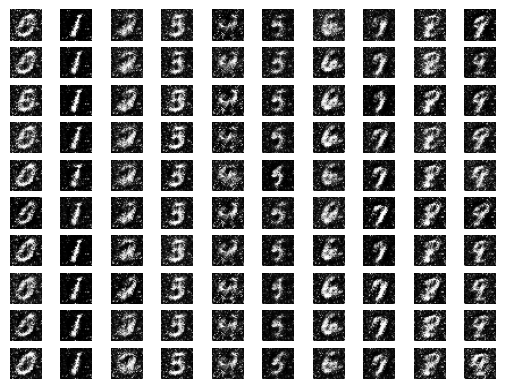

1/1 [==============================] - 0s 8ms/step
2001 [D loss: 1.0100293457508087, acc.: 28.76533716917038%] [G loss: 2.087742328643799]
1/1 [==============================] - 0s 9ms/step
2002 [D loss: 0.7048568427562714, acc.: 35.14908701181412%] [G loss: 2.234600067138672]
1/1 [==============================] - 0s 8ms/step
2003 [D loss: 1.0390106439590454, acc.: 35.11296808719635%] [G loss: 2.190945625305176]
1/1 [==============================] - 0s 9ms/step
2004 [D loss: 0.9747158288955688, acc.: 30.162987112998962%] [G loss: 2.3754031658172607]
1/1 [==============================] - 0s 9ms/step
2005 [D loss: 0.9448198676109314, acc.: 27.321551740169525%] [G loss: 2.0268337726593018]
1/1 [==============================] - 0s 8ms/step
2006 [D loss: 1.14839369058609, acc.: 32.811519503593445%] [G loss: 2.1788628101348877]
1/1 [==============================] - 0s 9ms/step
2007 [D loss: 0.8776888251304626, acc.: 29.873400926589966%] [G loss: 2.5875356197357178]
1/1 [================

1/1 [==============================] - 0s 9ms/step
2060 [D loss: 1.1679013967514038, acc.: 30.232441425323486%] [G loss: 2.194803237915039]
1/1 [==============================] - 0s 9ms/step
2061 [D loss: 0.9568356275558472, acc.: 30.75820356607437%] [G loss: 2.113429069519043]
1/1 [==============================] - 0s 10ms/step
2062 [D loss: 0.9265187382698059, acc.: 34.06229168176651%] [G loss: 2.3357744216918945]
1/1 [==============================] - 0s 8ms/step
2063 [D loss: 0.9894149601459503, acc.: 31.36872947216034%] [G loss: 2.2402336597442627]
1/1 [==============================] - 0s 10ms/step
2064 [D loss: 1.0714397132396698, acc.: 35.27924418449402%] [G loss: 2.306812286376953]
1/1 [==============================] - 0s 8ms/step
2065 [D loss: 0.9924520254135132, acc.: 29.930178821086884%] [G loss: 2.2194981575012207]
1/1 [==============================] - 0s 9ms/step
2066 [D loss: 1.1314541101455688, acc.: 32.17596262693405%] [G loss: 2.1073877811431885]
1/1 [==============

1/1 [==============================] - 0s 8ms/step
2119 [D loss: 1.0034038126468658, acc.: 29.20413166284561%] [G loss: 1.9004576206207275]
1/1 [==============================] - 0s 9ms/step
2120 [D loss: 1.0694513618946075, acc.: 35.6596365571022%] [G loss: 1.954219937324524]
1/1 [==============================] - 0s 9ms/step
2121 [D loss: 0.7959067523479462, acc.: 33.79785865545273%] [G loss: 2.1648168563842773]
1/1 [==============================] - 0s 9ms/step
2122 [D loss: 1.2104628682136536, acc.: 35.20645201206207%] [G loss: 1.9147614240646362]
1/1 [==============================] - 0s 8ms/step
2123 [D loss: 0.7510426640510559, acc.: 30.37521541118622%] [G loss: 1.9096715450286865]
1/1 [==============================] - 0s 9ms/step
2124 [D loss: 0.909826785326004, acc.: 30.547331273555756%] [G loss: 2.0922012329101562]
1/1 [==============================] - 0s 8ms/step
2125 [D loss: 0.7964963912963867, acc.: 27.975289523601532%] [G loss: 2.0878114700317383]
1/1 [================

1/1 [==============================] - 0s 9ms/step
2178 [D loss: 1.0491576492786407, acc.: 36.531421542167664%] [G loss: 1.8630692958831787]
1/1 [==============================] - 0s 8ms/step
2179 [D loss: 1.049035668373108, acc.: 36.89626753330231%] [G loss: 1.8121954202651978]
1/1 [==============================] - 0s 10ms/step
2180 [D loss: 0.8071478307247162, acc.: 31.185129284858704%] [G loss: 2.0471696853637695]
1/1 [==============================] - 0s 8ms/step
2181 [D loss: 0.8400416076183319, acc.: 33.01045596599579%] [G loss: 2.1187903881073]
1/1 [==============================] - 0s 9ms/step
2182 [D loss: 0.8137164115905762, acc.: 28.0002161860466%] [G loss: 1.935567855834961]
1/1 [==============================] - 0s 8ms/step
2183 [D loss: 0.8035912215709686, acc.: 32.671211659908295%] [G loss: 1.9452821016311646]
1/1 [==============================] - 0s 8ms/step
2184 [D loss: 1.123361200094223, acc.: 39.224252104759216%] [G loss: 2.1852211952209473]
1/1 [=================

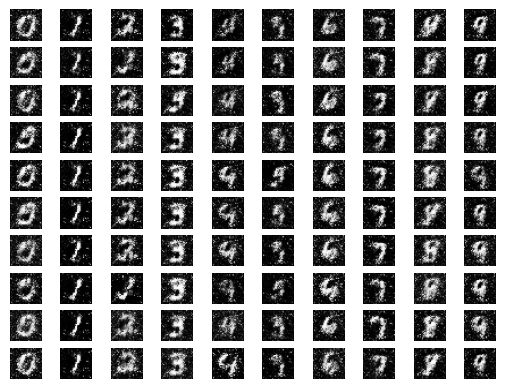

1/1 [==============================] - 0s 9ms/step
2201 [D loss: 0.9253952205181122, acc.: 35.3714644908905%] [G loss: 1.7869967222213745]
1/1 [==============================] - 0s 8ms/step
2202 [D loss: 0.9041888117790222, acc.: 34.181901812553406%] [G loss: 1.8454951047897339]
1/1 [==============================] - 0s 9ms/step
2203 [D loss: 0.8793626427650452, acc.: 37.59630173444748%] [G loss: 1.9952664375305176]
1/1 [==============================] - 0s 8ms/step
2204 [D loss: 0.9131144881248474, acc.: 32.231760025024414%] [G loss: 1.7774012088775635]
1/1 [==============================] - 0s 8ms/step
2205 [D loss: 0.8638677597045898, acc.: 31.725376844406128%] [G loss: 1.9701327085494995]
1/1 [==============================] - 0s 8ms/step
2206 [D loss: 0.984663188457489, acc.: 38.45754861831665%] [G loss: 1.9902719259262085]
1/1 [==============================] - 0s 8ms/step
2207 [D loss: 0.8549852669239044, acc.: 22.159378230571747%] [G loss: 1.819196343421936]
1/1 [==============

1/1 [==============================] - 0s 8ms/step
2260 [D loss: 0.9005275666713715, acc.: 35.083481669425964%] [G loss: 2.5824663639068604]
1/1 [==============================] - 0s 8ms/step
2261 [D loss: 1.254665583372116, acc.: 34.02632623910904%] [G loss: 2.1641182899475098]
1/1 [==============================] - 0s 9ms/step
2262 [D loss: 0.904566079378128, acc.: 31.60984367132187%] [G loss: 2.606175661087036]
1/1 [==============================] - 0s 8ms/step
2263 [D loss: 0.763372927904129, acc.: 29.258038103580475%] [G loss: 2.5205070972442627]
1/1 [==============================] - 0s 8ms/step
2264 [D loss: 1.034383863210678, acc.: 39.616912603378296%] [G loss: 2.2255594730377197]
1/1 [==============================] - 0s 8ms/step
2265 [D loss: 0.8994224071502686, acc.: 33.036091923713684%] [G loss: 2.450867176055908]
1/1 [==============================] - 0s 8ms/step
2266 [D loss: 0.8889094293117523, acc.: 31.616301834583282%] [G loss: 2.5284719467163086]
1/1 [================

1/1 [==============================] - 0s 10ms/step
2319 [D loss: 0.8744072616100311, acc.: 33.44426602125168%] [G loss: 2.003920078277588]
1/1 [==============================] - 0s 9ms/step
2320 [D loss: 0.9877768754959106, acc.: 31.349186599254608%] [G loss: 1.9989930391311646]
1/1 [==============================] - 0s 8ms/step
2321 [D loss: 1.0129700005054474, acc.: 35.78758388757706%] [G loss: 2.020775556564331]
1/1 [==============================] - 0s 8ms/step
2322 [D loss: 0.9716671407222748, acc.: 32.17635154724121%] [G loss: 1.7845728397369385]
1/1 [==============================] - 0s 9ms/step
2323 [D loss: 0.9365928471088409, acc.: 33.700692653656006%] [G loss: 1.980692744255066]
1/1 [==============================] - 0s 9ms/step
2324 [D loss: 0.9062853753566742, acc.: 40.23417830467224%] [G loss: 2.2064173221588135]
1/1 [==============================] - 0s 8ms/step
2325 [D loss: 0.9692980945110321, acc.: 34.19948220252991%] [G loss: 1.881726861000061]
1/1 [================

1/1 [==============================] - 0s 9ms/step
2378 [D loss: 1.1925800442695618, acc.: 25.886335968971252%] [G loss: 2.5333573818206787]
1/1 [==============================] - 0s 8ms/step
2379 [D loss: 1.1754514873027802, acc.: 37.47871816158295%] [G loss: 2.163640022277832]
1/1 [==============================] - 0s 8ms/step
2380 [D loss: 1.135603666305542, acc.: 31.509380042552948%] [G loss: 1.9965837001800537]
1/1 [==============================] - 0s 9ms/step
2381 [D loss: 0.9511261284351349, acc.: 34.1863676905632%] [G loss: 2.208771228790283]
1/1 [==============================] - 0s 8ms/step
2382 [D loss: 1.3486270308494568, acc.: 36.74941956996918%] [G loss: 2.406578302383423]
1/1 [==============================] - 0s 9ms/step
2383 [D loss: 1.0590539574623108, acc.: 33.82471054792404%] [G loss: 2.181331157684326]
1/1 [==============================] - 0s 8ms/step
2384 [D loss: 1.191776692867279, acc.: 34.542518854141235%] [G loss: 2.109086513519287]
1/1 [====================

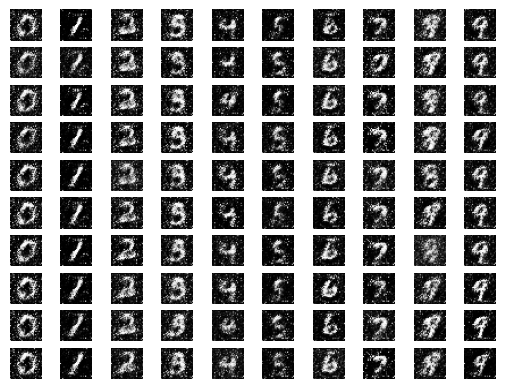

1/1 [==============================] - 0s 10ms/step
2401 [D loss: 0.9482367038726807, acc.: 32.927365601062775%] [G loss: 1.9634599685668945]
1/1 [==============================] - 0s 9ms/step
2402 [D loss: 0.770335465669632, acc.: 28.367896378040314%] [G loss: 2.011861562728882]
1/1 [==============================] - 0s 10ms/step
2403 [D loss: 0.8796318173408508, acc.: 26.531709730625153%] [G loss: 1.9909336566925049]
1/1 [==============================] - 0s 8ms/step
2404 [D loss: 0.8668164908885956, acc.: 32.5064554810524%] [G loss: 1.9215055704116821]
1/1 [==============================] - 0s 10ms/step
2405 [D loss: 0.8558435142040253, acc.: 36.786045134067535%] [G loss: 1.9620879888534546]
1/1 [==============================] - 0s 8ms/step
2406 [D loss: 0.9908608794212341, acc.: 39.595092833042145%] [G loss: 1.805743932723999]
1/1 [==============================] - 0s 9ms/step
2407 [D loss: 0.9345864355564117, acc.: 32.954370975494385%] [G loss: 1.824994444847107]
1/1 [===========

1/1 [==============================] - 0s 9ms/step
2460 [D loss: 0.9904962182044983, acc.: 35.825784504413605%] [G loss: 1.6136045455932617]
1/1 [==============================] - 0s 10ms/step
2461 [D loss: 0.9587449431419373, acc.: 32.03583061695099%] [G loss: 1.8870575428009033]
1/1 [==============================] - 0s 8ms/step
2462 [D loss: 0.8085016012191772, acc.: 27.273088693618774%] [G loss: 2.091113567352295]
1/1 [==============================] - 0s 8ms/step
2463 [D loss: 1.1745492219924927, acc.: 28.823769092559814%] [G loss: 1.8007394075393677]
1/1 [==============================] - 0s 8ms/step
2464 [D loss: 0.9115518927574158, acc.: 30.051565170288086%] [G loss: 1.854272723197937]
1/1 [==============================] - 0s 8ms/step
2465 [D loss: 0.9155818521976471, acc.: 30.98599910736084%] [G loss: 1.9426279067993164]
1/1 [==============================] - 0s 8ms/step
2466 [D loss: 0.9132544696331024, acc.: 31.01520538330078%] [G loss: 2.0768990516662598]
1/1 [============

1/1 [==============================] - 0s 8ms/step
2519 [D loss: 0.8550187945365906, acc.: 36.88015788793564%] [G loss: 1.942151665687561]
1/1 [==============================] - 0s 9ms/step
2520 [D loss: 0.9114851355552673, acc.: 33.07201266288757%] [G loss: 1.9728459119796753]
1/1 [==============================] - 0s 8ms/step
2521 [D loss: 0.8377767205238342, acc.: 37.77941316366196%] [G loss: 1.8149467706680298]
1/1 [==============================] - 0s 9ms/step
2522 [D loss: 0.86529541015625, acc.: 29.252538084983826%] [G loss: 1.9691067934036255]
1/1 [==============================] - 0s 8ms/step
2523 [D loss: 0.9210423529148102, acc.: 32.97594040632248%] [G loss: 1.7675563097000122]
1/1 [==============================] - 0s 8ms/step
2524 [D loss: 1.0372590124607086, acc.: 31.608855724334717%] [G loss: 1.5841082334518433]
1/1 [==============================] - 0s 10ms/step
2525 [D loss: 0.8401094377040863, acc.: 31.990009546279907%] [G loss: 1.7936538457870483]
1/1 [==============

1/1 [==============================] - 0s 8ms/step
2578 [D loss: 0.9516029953956604, acc.: 30.88161200284958%] [G loss: 2.0109403133392334]
1/1 [==============================] - 0s 9ms/step
2579 [D loss: 1.001758635044098, acc.: 34.60882157087326%] [G loss: 2.0660688877105713]
1/1 [==============================] - 0s 8ms/step
2580 [D loss: 1.0227848291397095, acc.: 40.88767170906067%] [G loss: 2.4003357887268066]
1/1 [==============================] - 0s 9ms/step
2581 [D loss: 1.0059162080287933, acc.: 36.052405834198%] [G loss: 2.408353090286255]
1/1 [==============================] - 0s 8ms/step
2582 [D loss: 0.9725195169448853, acc.: 40.190888941287994%] [G loss: 2.2344534397125244]
1/1 [==============================] - 0s 10ms/step
2583 [D loss: 0.8122260868549347, acc.: 30.994775891304016%] [G loss: 2.325793981552124]
1/1 [==============================] - 0s 9ms/step
2584 [D loss: 0.7812072932720184, acc.: 30.88116943836212%] [G loss: 2.5789337158203125]
1/1 [=================

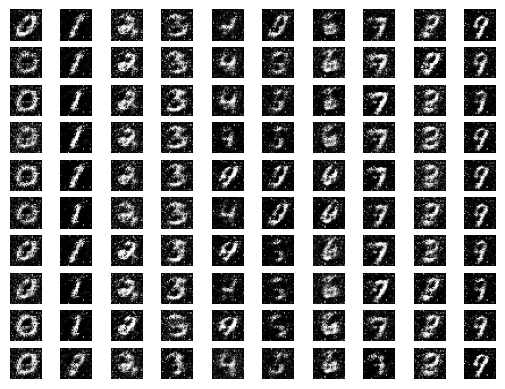

1/1 [==============================] - 0s 10ms/step
2601 [D loss: 1.12410306930542, acc.: 42.37373173236847%] [G loss: 1.9189884662628174]
1/1 [==============================] - 0s 10ms/step
2602 [D loss: 0.8809978663921356, acc.: 33.297544717788696%] [G loss: 1.8191545009613037]
1/1 [==============================] - 0s 8ms/step
2603 [D loss: 0.8120401203632355, acc.: 36.577217280864716%] [G loss: 2.212216377258301]
1/1 [==============================] - 0s 8ms/step
2604 [D loss: 0.981305718421936, acc.: 28.060173988342285%] [G loss: 2.0425398349761963]
1/1 [==============================] - 0s 8ms/step
2605 [D loss: 0.8704736530780792, acc.: 31.959620118141174%] [G loss: 2.079989433288574]
1/1 [==============================] - 0s 9ms/step
2606 [D loss: 0.9231135249137878, acc.: 25.66787153482437%] [G loss: 2.0641679763793945]
1/1 [==============================] - 0s 8ms/step
2607 [D loss: 0.9412168264389038, acc.: 30.23664802312851%] [G loss: 1.8520522117614746]
1/1 [==============

1/1 [==============================] - 0s 9ms/step
2660 [D loss: 0.8988311588764191, acc.: 31.946325302124023%] [G loss: 1.9639428853988647]
1/1 [==============================] - 0s 10ms/step
2661 [D loss: 0.8868605494499207, acc.: 36.92848980426788%] [G loss: 2.2607920169830322]
1/1 [==============================] - 0s 9ms/step
2662 [D loss: 1.0315314829349518, acc.: 38.42444270849228%] [G loss: 1.8225123882293701]
1/1 [==============================] - 0s 10ms/step
2663 [D loss: 1.2001859247684479, acc.: 34.26869213581085%] [G loss: 1.9392356872558594]
1/1 [==============================] - 0s 10ms/step
2664 [D loss: 1.0906827449798584, acc.: 35.5958417057991%] [G loss: 2.0873775482177734]
1/1 [==============================] - 0s 9ms/step
2665 [D loss: 0.992176353931427, acc.: 35.29718816280365%] [G loss: 2.1285133361816406]
1/1 [==============================] - 0s 9ms/step
2666 [D loss: 0.8711841404438019, acc.: 30.619364976882935%] [G loss: 2.0296525955200195]
1/1 [============

1/1 [==============================] - 0s 8ms/step
2719 [D loss: 1.0129022598266602, acc.: 31.79323822259903%] [G loss: 1.9131739139556885]
1/1 [==============================] - 0s 8ms/step
2720 [D loss: 0.7741914093494415, acc.: 33.34491550922394%] [G loss: 1.9296320676803589]
1/1 [==============================] - 0s 9ms/step
2721 [D loss: 0.7415677905082703, acc.: 27.728542685508728%] [G loss: 2.061633348464966]
1/1 [==============================] - 0s 8ms/step
2722 [D loss: 0.833253026008606, acc.: 30.468927323818207%] [G loss: 1.9607936143875122]
1/1 [==============================] - 0s 8ms/step
2723 [D loss: 0.9097138047218323, acc.: 33.44268649816513%] [G loss: 1.8057670593261719]
1/1 [==============================] - 0s 8ms/step
2724 [D loss: 0.9147577285766602, acc.: 35.534413158893585%] [G loss: 2.0051820278167725]
1/1 [==============================] - 0s 8ms/step
2725 [D loss: 0.9795591831207275, acc.: 28.15760374069214%] [G loss: 2.0784871578216553]
1/1 [==============

1/1 [==============================] - 0s 8ms/step
2778 [D loss: 0.8238115310668945, acc.: 35.95643490552902%] [G loss: 2.2154757976531982]
1/1 [==============================] - 0s 9ms/step
2779 [D loss: 0.8146266043186188, acc.: 31.78519904613495%] [G loss: 2.1168720722198486]
1/1 [==============================] - 0s 8ms/step
2780 [D loss: 1.1091667711734772, acc.: 33.96243005990982%] [G loss: 1.9362353086471558]
1/1 [==============================] - 0s 10ms/step
2781 [D loss: 0.9781832098960876, acc.: 35.026490688323975%] [G loss: 1.8497459888458252]
1/1 [==============================] - 0s 9ms/step
2782 [D loss: 0.9913276135921478, acc.: 37.201590836048126%] [G loss: 1.9138094186782837]
1/1 [==============================] - 0s 9ms/step
2783 [D loss: 1.2169209122657776, acc.: 34.35659110546112%] [G loss: 1.7911547422409058]
1/1 [==============================] - 0s 8ms/step
2784 [D loss: 1.1471750736236572, acc.: 38.47127705812454%] [G loss: 1.7302477359771729]
1/1 [============

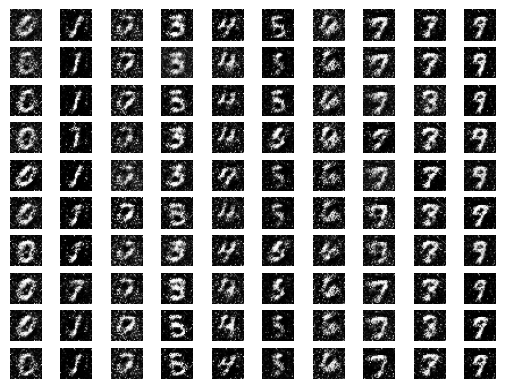

1/1 [==============================] - 0s 14ms/step
2801 [D loss: 1.0434555411338806, acc.: 31.803175806999207%] [G loss: 1.8889493942260742]
1/1 [==============================] - 0s 8ms/step
2802 [D loss: 1.0617462992668152, acc.: 28.336329758167267%] [G loss: 1.8817495107650757]
1/1 [==============================] - 0s 8ms/step
2803 [D loss: 0.9616425931453705, acc.: 35.75083166360855%] [G loss: 1.984920620918274]
1/1 [==============================] - 0s 9ms/step
2804 [D loss: 1.0911743640899658, acc.: 38.9969602227211%] [G loss: 2.1437647342681885]
1/1 [==============================] - 0s 9ms/step
2805 [D loss: 0.8277768194675446, acc.: 34.520018100738525%] [G loss: 2.0332117080688477]
1/1 [==============================] - 0s 8ms/step
2806 [D loss: 0.853217601776123, acc.: 31.903567910194397%] [G loss: 2.0112526416778564]
1/1 [==============================] - 0s 8ms/step
2807 [D loss: 1.0548937320709229, acc.: 29.537290334701538%] [G loss: 2.324026107788086]
1/1 [=============

1/1 [==============================] - 0s 8ms/step
2860 [D loss: 1.0638112127780914, acc.: 32.94721245765686%] [G loss: 1.7252739667892456]
1/1 [==============================] - 0s 9ms/step
2861 [D loss: 0.91065314412117, acc.: 33.17248374223709%] [G loss: 1.9045593738555908]
1/1 [==============================] - 0s 8ms/step
2862 [D loss: 0.92247673869133, acc.: 35.30668616294861%] [G loss: 1.910646915435791]
1/1 [==============================] - 0s 11ms/step
2863 [D loss: 1.1570273339748383, acc.: 37.35458552837372%] [G loss: 2.303704261779785]
1/1 [==============================] - 0s 9ms/step
2864 [D loss: 1.140091896057129, acc.: 37.441496551036835%] [G loss: 1.867695689201355]
1/1 [==============================] - 0s 8ms/step
2865 [D loss: 0.9153382778167725, acc.: 35.24262607097626%] [G loss: 1.94425368309021]
1/1 [==============================] - 0s 9ms/step
2866 [D loss: 0.9675588011741638, acc.: 34.207019209861755%] [G loss: 2.1651294231414795]
1/1 [======================

1/1 [==============================] - 0s 9ms/step
2919 [D loss: 0.8679975867271423, acc.: 34.102872014045715%] [G loss: 2.0318527221679688]
1/1 [==============================] - 0s 9ms/step
2920 [D loss: 0.9760430753231049, acc.: 35.06091982126236%] [G loss: 1.9182238578796387]
1/1 [==============================] - 0s 10ms/step
2921 [D loss: 0.8693374693393707, acc.: 32.59036988019943%] [G loss: 1.802341341972351]
1/1 [==============================] - 0s 11ms/step
2922 [D loss: 1.1334435641765594, acc.: 34.33612883090973%] [G loss: 1.7542341947555542]
1/1 [==============================] - 0s 9ms/step
2923 [D loss: 1.0065666735172272, acc.: 24.68840554356575%] [G loss: 2.065390110015869]
1/1 [==============================] - 0s 8ms/step
2924 [D loss: 0.9543631970882416, acc.: 38.77436816692352%] [G loss: 1.9149006605148315]
1/1 [==============================] - 0s 10ms/step
2925 [D loss: 0.8945831954479218, acc.: 30.094364285469055%] [G loss: 1.9976264238357544]
1/1 [============

1/1 [==============================] - 0s 9ms/step
2978 [D loss: 0.9181447923183441, acc.: 28.505904972553253%] [G loss: 1.9408589601516724]
1/1 [==============================] - 0s 9ms/step
2979 [D loss: 0.9084729850292206, acc.: 35.78368276357651%] [G loss: 2.0193216800689697]
1/1 [==============================] - 0s 9ms/step
2980 [D loss: 0.9273898601531982, acc.: 39.90829437971115%] [G loss: 1.9460810422897339]
1/1 [==============================] - 0s 9ms/step
2981 [D loss: 0.8638689815998077, acc.: 28.654560446739197%] [G loss: 1.9052183628082275]
1/1 [==============================] - 0s 9ms/step
2982 [D loss: 1.0847135186195374, acc.: 31.068602204322815%] [G loss: 2.0944745540618896]
1/1 [==============================] - 0s 8ms/step
2983 [D loss: 0.9568608403205872, acc.: 34.46979820728302%] [G loss: 1.9633440971374512]
1/1 [==============================] - 0s 8ms/step
2984 [D loss: 0.833276093006134, acc.: 34.92827117443085%] [G loss: 1.8344411849975586]
1/1 [=============

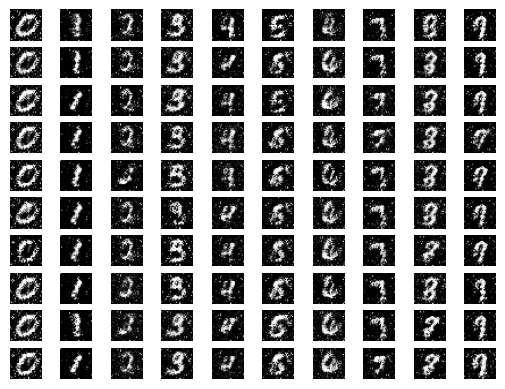

1/1 [==============================] - 0s 10ms/step
3001 [D loss: 1.009358137845993, acc.: 35.661108791828156%] [G loss: 1.9537707567214966]
1/1 [==============================] - 0s 9ms/step
3002 [D loss: 0.8762699663639069, acc.: 34.50232744216919%] [G loss: 2.5089879035949707]
1/1 [==============================] - 0s 8ms/step
3003 [D loss: 1.005350798368454, acc.: 33.261699974536896%] [G loss: 2.11515736579895]
1/1 [==============================] - 0s 8ms/step
3004 [D loss: 0.7239820957183838, acc.: 30.192571878433228%] [G loss: 2.101806879043579]
1/1 [==============================] - 0s 8ms/step
3005 [D loss: 0.8695118725299835, acc.: 34.42027270793915%] [G loss: 2.120558977127075]
1/1 [==============================] - 0s 8ms/step
3006 [D loss: 0.818542867898941, acc.: 36.21500879526138%] [G loss: 2.1412487030029297]
1/1 [==============================] - 0s 9ms/step
3007 [D loss: 1.0205647945404053, acc.: 34.83857810497284%] [G loss: 2.26222825050354]
1/1 [====================

1/1 [==============================] - 0s 10ms/step
3060 [D loss: 1.0164498090744019, acc.: 36.54233068227768%] [G loss: 1.728110671043396]
1/1 [==============================] - 0s 9ms/step
3061 [D loss: 0.9969578385353088, acc.: 31.50027096271515%] [G loss: 1.897903323173523]
1/1 [==============================] - 0s 8ms/step
3062 [D loss: 0.9175421595573425, acc.: 33.89449119567871%] [G loss: 1.9752613306045532]
1/1 [==============================] - 0s 9ms/step
3063 [D loss: 0.9734580218791962, acc.: 37.27853298187256%] [G loss: 1.837544560432434]
1/1 [==============================] - 0s 8ms/step
3064 [D loss: 0.9661036431789398, acc.: 32.81927853822708%] [G loss: 1.9142251014709473]
1/1 [==============================] - 0s 9ms/step
3065 [D loss: 0.762641191482544, acc.: 29.513368010520935%] [G loss: 1.9102392196655273]
1/1 [==============================] - 0s 10ms/step
3066 [D loss: 0.8743810653686523, acc.: 44.35932636260986%] [G loss: 2.394529342651367]
1/1 [=================

1/1 [==============================] - 0s 8ms/step
3119 [D loss: 0.9026973247528076, acc.: 31.196416914463043%] [G loss: 1.8654444217681885]
1/1 [==============================] - 0s 9ms/step
3120 [D loss: 1.0162676274776459, acc.: 38.31310719251633%] [G loss: 1.9135617017745972]
1/1 [==============================] - 0s 8ms/step
3121 [D loss: 1.0716796517372131, acc.: 39.44684565067291%] [G loss: 2.1523261070251465]
1/1 [==============================] - 0s 9ms/step
3122 [D loss: 1.3184371590614319, acc.: 38.34298104047775%] [G loss: 2.071255683898926]
1/1 [==============================] - 0s 8ms/step
3123 [D loss: 1.0694087445735931, acc.: 37.619708478450775%] [G loss: 2.0914385318756104]
1/1 [==============================] - 0s 8ms/step
3124 [D loss: 0.9284529089927673, acc.: 29.72051352262497%] [G loss: 2.087512731552124]
1/1 [==============================] - 0s 9ms/step
3125 [D loss: 0.910949170589447, acc.: 30.38240224123001%] [G loss: 2.1671688556671143]
1/1 [================

1/1 [==============================] - 0s 9ms/step
3178 [D loss: 1.1341434717178345, acc.: 35.99903732538223%] [G loss: 1.9263962507247925]
1/1 [==============================] - 0s 9ms/step
3179 [D loss: 0.9585510790348053, acc.: 30.15897274017334%] [G loss: 2.0901143550872803]
1/1 [==============================] - 0s 10ms/step
3180 [D loss: 1.1009815335273743, acc.: 34.605373442173004%] [G loss: 2.0384998321533203]
1/1 [==============================] - 0s 8ms/step
3181 [D loss: 1.0047304332256317, acc.: 40.130406618118286%] [G loss: 2.018329381942749]
1/1 [==============================] - 0s 8ms/step
3182 [D loss: 0.8255127668380737, acc.: 32.37667381763458%] [G loss: 1.7544275522232056]
1/1 [==============================] - 0s 9ms/step
3183 [D loss: 0.8908562064170837, acc.: 35.354578495025635%] [G loss: 1.8365402221679688]
1/1 [==============================] - 0s 8ms/step
3184 [D loss: 0.7943084239959717, acc.: 36.865465342998505%] [G loss: 1.9430136680603027]
1/1 [===========

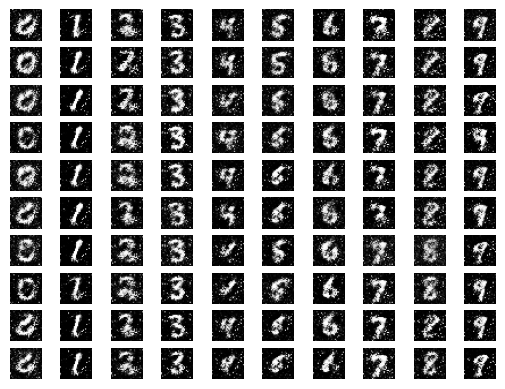

1/1 [==============================] - 0s 8ms/step
3201 [D loss: 0.9044378399848938, acc.: 32.100868225097656%] [G loss: 2.0829410552978516]
1/1 [==============================] - 0s 9ms/step
3202 [D loss: 0.8463750779628754, acc.: 29.49182689189911%] [G loss: 2.111304759979248]
1/1 [==============================] - 0s 9ms/step
3203 [D loss: 1.0005705654621124, acc.: 33.36133062839508%] [G loss: 1.9836598634719849]
1/1 [==============================] - 0s 9ms/step
3204 [D loss: 0.8344387412071228, acc.: 30.821511149406433%] [G loss: 1.7679996490478516]
1/1 [==============================] - 0s 8ms/step
3205 [D loss: 0.9899919927120209, acc.: 31.352803111076355%] [G loss: 1.743910789489746]
1/1 [==============================] - 0s 8ms/step
3206 [D loss: 1.2108532190322876, acc.: 34.83486920595169%] [G loss: 1.664384365081787]
1/1 [==============================] - 0s 9ms/step
3207 [D loss: 0.8670051097869873, acc.: 34.9686324596405%] [G loss: 1.9791067838668823]
1/1 [================

1/1 [==============================] - 0s 8ms/step
3260 [D loss: 0.9522007405757904, acc.: 30.58410733938217%] [G loss: 2.09102201461792]
1/1 [==============================] - 0s 9ms/step
3261 [D loss: 0.9140403866767883, acc.: 36.0969603061676%] [G loss: 1.8626052141189575]
1/1 [==============================] - 0s 8ms/step
3262 [D loss: 1.058673083782196, acc.: 42.3709899187088%] [G loss: 1.917283296585083]
1/1 [==============================] - 0s 11ms/step
3263 [D loss: 0.8459747433662415, acc.: 31.355002522468567%] [G loss: 2.1433651447296143]
1/1 [==============================] - 0s 12ms/step
3264 [D loss: 1.1258714497089386, acc.: 30.15204221010208%] [G loss: 1.6518373489379883]
1/1 [==============================] - 0s 9ms/step
3265 [D loss: 0.9319959580898285, acc.: 31.82307779788971%] [G loss: 1.6531517505645752]
1/1 [==============================] - 0s 10ms/step
3266 [D loss: 0.8863746821880341, acc.: 33.4109365940094%] [G loss: 2.0267484188079834]
1/1 [==================

1/1 [==============================] - 0s 8ms/step
3319 [D loss: 0.8585352599620819, acc.: 31.017515063285828%] [G loss: 1.763115406036377]
1/1 [==============================] - 0s 9ms/step
3320 [D loss: 1.0132405161857605, acc.: 30.13254851102829%] [G loss: 1.819982647895813]
1/1 [==============================] - 0s 10ms/step
3321 [D loss: 0.890954852104187, acc.: 34.70311760902405%] [G loss: 2.012603998184204]
1/1 [==============================] - 0s 8ms/step
3322 [D loss: 1.1183599829673767, acc.: 41.32721424102783%] [G loss: 1.895561933517456]
1/1 [==============================] - 0s 8ms/step
3323 [D loss: 1.145871341228485, acc.: 33.76010209321976%] [G loss: 1.524656891822815]
1/1 [==============================] - 0s 8ms/step
3324 [D loss: 1.1080095767974854, acc.: 28.587034344673157%] [G loss: 1.7518796920776367]
1/1 [==============================] - 0s 9ms/step
3325 [D loss: 1.0602135956287384, acc.: 33.472929894924164%] [G loss: 1.7377890348434448]
1/1 [==================

1/1 [==============================] - 0s 9ms/step
3378 [D loss: 1.0590741634368896, acc.: 33.579425513744354%] [G loss: 1.738196849822998]
1/1 [==============================] - 0s 8ms/step
3379 [D loss: 1.1545798778533936, acc.: 34.07886177301407%] [G loss: 1.7752035856246948]
1/1 [==============================] - 0s 11ms/step
3380 [D loss: 1.0431369543075562, acc.: 37.53220587968826%] [G loss: 1.9864985942840576]
1/1 [==============================] - 0s 8ms/step
3381 [D loss: 0.7923486530780792, acc.: 27.10399478673935%] [G loss: 1.9995604753494263]
1/1 [==============================] - 0s 8ms/step
3382 [D loss: 1.1802144646644592, acc.: 31.603990495204926%] [G loss: 1.880476713180542]
1/1 [==============================] - 0s 9ms/step
3383 [D loss: 0.9864675998687744, acc.: 31.236843764781952%] [G loss: 1.8798688650131226]
1/1 [==============================] - 0s 9ms/step
3384 [D loss: 1.0431589484214783, acc.: 38.80178928375244%] [G loss: 1.775151252746582]
1/1 [==============

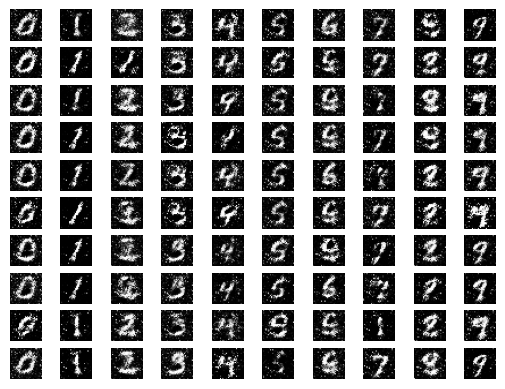

1/1 [==============================] - 0s 10ms/step
3401 [D loss: 1.1078545451164246, acc.: 29.526589810848236%] [G loss: 1.8772143125534058]
1/1 [==============================] - 0s 11ms/step
3402 [D loss: 1.0298025012016296, acc.: 38.901305198669434%] [G loss: 1.9708631038665771]
1/1 [==============================] - 0s 9ms/step
3403 [D loss: 0.9217952787876129, acc.: 33.20637047290802%] [G loss: 1.9392458200454712]
1/1 [==============================] - 0s 8ms/step
3404 [D loss: 0.9876034557819366, acc.: 30.834414064884186%] [G loss: 2.043647527694702]
1/1 [==============================] - 0s 8ms/step
3405 [D loss: 1.1729064285755157, acc.: 35.84323525428772%] [G loss: 2.017108201980591]
1/1 [==============================] - 0s 8ms/step
3406 [D loss: 0.7808503210544586, acc.: 31.462113559246063%] [G loss: 1.8865394592285156]
1/1 [==============================] - 0s 10ms/step
3407 [D loss: 0.9361584782600403, acc.: 40.37014991044998%] [G loss: 1.787494421005249]
1/1 [===========

1/1 [==============================] - 0s 8ms/step
3460 [D loss: 0.9856723845005035, acc.: 36.144717037677765%] [G loss: 1.6958307027816772]
1/1 [==============================] - 0s 9ms/step
3461 [D loss: 1.0135855078697205, acc.: 38.84352892637253%] [G loss: 1.8622220754623413]
1/1 [==============================] - 0s 9ms/step
3462 [D loss: 0.9692992269992828, acc.: 32.64722526073456%] [G loss: 1.849536418914795]
1/1 [==============================] - 0s 8ms/step
3463 [D loss: 0.9437646865844727, acc.: 31.65532648563385%] [G loss: 1.6943079233169556]
1/1 [==============================] - 0s 8ms/step
3464 [D loss: 1.0339490175247192, acc.: 39.558808505535126%] [G loss: 1.6213574409484863]
1/1 [==============================] - 0s 8ms/step
3465 [D loss: 0.9646138548851013, acc.: 37.400369346141815%] [G loss: 1.6218883991241455]
1/1 [==============================] - 0s 8ms/step
3466 [D loss: 1.208855926990509, acc.: 29.912924766540527%] [G loss: 1.5612173080444336]
1/1 [=============

1/1 [==============================] - 0s 9ms/step
3519 [D loss: 1.1588643789291382, acc.: 31.598250567913055%] [G loss: 1.7006750106811523]
1/1 [==============================] - 0s 10ms/step
3520 [D loss: 0.9561643600463867, acc.: 30.11755347251892%] [G loss: 1.7213516235351562]
1/1 [==============================] - 0s 8ms/step
3521 [D loss: 1.238003671169281, acc.: 37.553830444812775%] [G loss: 1.5334663391113281]
1/1 [==============================] - 0s 8ms/step
3522 [D loss: 0.9382466673851013, acc.: 27.125538885593414%] [G loss: 1.9537510871887207]
1/1 [==============================] - 0s 8ms/step
3523 [D loss: 0.973397970199585, acc.: 32.73105025291443%] [G loss: 1.857745885848999]
1/1 [==============================] - 0s 9ms/step
3524 [D loss: 1.0778070092201233, acc.: 33.31892639398575%] [G loss: 1.8028581142425537]
1/1 [==============================] - 0s 8ms/step
3525 [D loss: 1.1603626012802124, acc.: 37.81602084636688%] [G loss: 1.5342596769332886]
1/1 [==============

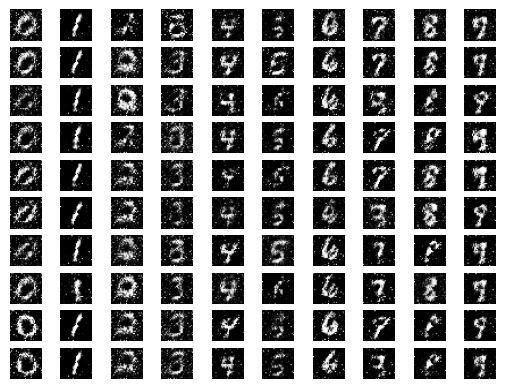

1/1 [==============================] - 0s 9ms/step
3601 [D loss: 0.8197967410087585, acc.: 31.190413236618042%] [G loss: 2.1202194690704346]
1/1 [==============================] - 0s 10ms/step
3602 [D loss: 1.0466657876968384, acc.: 35.975927114486694%] [G loss: 1.8789657354354858]
1/1 [==============================] - 0s 10ms/step
3603 [D loss: 1.006911277770996, acc.: 32.5121209025383%] [G loss: 1.7676488161087036]
1/1 [==============================] - 0s 9ms/step
3604 [D loss: 1.1636460423469543, acc.: 36.71830594539642%] [G loss: 1.8000595569610596]
1/1 [==============================] - 0s 12ms/step
3605 [D loss: 1.009956181049347, acc.: 38.16816806793213%] [G loss: 1.9006589651107788]
1/1 [==============================] - 0s 10ms/step
3606 [D loss: 0.9654898643493652, acc.: 35.0416898727417%] [G loss: 1.708901047706604]
1/1 [==============================] - 0s 9ms/step
3607 [D loss: 1.222718358039856, acc.: 35.10813117027283%] [G loss: 1.5167872905731201]
1/1 [===============

1/1 [==============================] - 0s 8ms/step
3660 [D loss: 1.2410271763801575, acc.: 31.189167499542236%] [G loss: 2.060136318206787]
1/1 [==============================] - 0s 8ms/step
3661 [D loss: 0.9936092793941498, acc.: 30.3931787610054%] [G loss: 1.774181842803955]
1/1 [==============================] - 0s 9ms/step
3662 [D loss: 1.0325675904750824, acc.: 35.15746295452118%] [G loss: 1.7803648710250854]
1/1 [==============================] - 0s 8ms/step
3663 [D loss: 1.0792039334774017, acc.: 33.59005153179169%] [G loss: 1.6788616180419922]
1/1 [==============================] - 0s 8ms/step
3664 [D loss: 0.8698305189609528, acc.: 31.522923707962036%] [G loss: 1.9679335355758667]
1/1 [==============================] - 0s 8ms/step
3665 [D loss: 0.9942776560783386, acc.: 29.136843979358673%] [G loss: 2.0271501541137695]
1/1 [==============================] - 0s 9ms/step
3666 [D loss: 0.9309239685535431, acc.: 31.702855229377747%] [G loss: 2.101086378097534]
1/1 [===============

1/1 [==============================] - 0s 8ms/step
3719 [D loss: 0.8458894789218903, acc.: 33.52501839399338%] [G loss: 1.9779679775238037]
1/1 [==============================] - 0s 8ms/step
3720 [D loss: 0.8824197053909302, acc.: 31.734083592891693%] [G loss: 1.7814443111419678]
1/1 [==============================] - 0s 8ms/step
3721 [D loss: 0.8912278711795807, acc.: 34.1528981924057%] [G loss: 1.7394953966140747]
1/1 [==============================] - 0s 10ms/step
3722 [D loss: 0.8901472091674805, acc.: 30.29714822769165%] [G loss: 1.7734698057174683]
1/1 [==============================] - 0s 9ms/step
3723 [D loss: 1.0300940871238708, acc.: 31.35732114315033%] [G loss: 1.8324230909347534]
1/1 [==============================] - 0s 8ms/step
3724 [D loss: 0.8616333901882172, acc.: 34.34542864561081%] [G loss: 1.8667515516281128]
1/1 [==============================] - 0s 10ms/step
3725 [D loss: 1.030858039855957, acc.: 30.597147345542908%] [G loss: 1.5942420959472656]
1/1 [=============

1/1 [==============================] - 0s 8ms/step
3778 [D loss: 1.0170679688453674, acc.: 35.93000769615173%] [G loss: 1.6714948415756226]
1/1 [==============================] - 0s 8ms/step
3779 [D loss: 1.037649154663086, acc.: 36.72604858875275%] [G loss: 1.758759617805481]
1/1 [==============================] - 0s 11ms/step
3780 [D loss: 0.832761287689209, acc.: 33.459605276584625%] [G loss: 1.8944792747497559]
1/1 [==============================] - 0s 8ms/step
3781 [D loss: 0.9171970784664154, acc.: 32.35470652580261%] [G loss: 1.849987268447876]
1/1 [==============================] - 0s 8ms/step
3782 [D loss: 0.8486129939556122, acc.: 27.37274467945099%] [G loss: 1.9026349782943726]
1/1 [==============================] - 0s 8ms/step
3783 [D loss: 0.8978492617607117, acc.: 31.466539204120636%] [G loss: 2.2473256587982178]
1/1 [==============================] - 0s 8ms/step
3784 [D loss: 0.8946777284145355, acc.: 33.1325888633728%] [G loss: 1.8679431676864624]
1/1 [=================

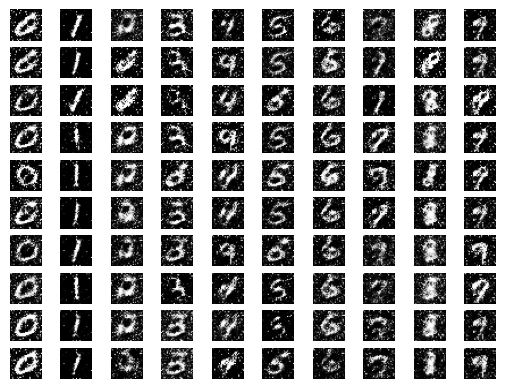

1/1 [==============================] - 0s 8ms/step
3801 [D loss: 0.8821001648902893, acc.: 30.675694346427917%] [G loss: 1.7919890880584717]
1/1 [==============================] - 0s 10ms/step
3802 [D loss: 1.2195807695388794, acc.: 35.49658954143524%] [G loss: 1.7978780269622803]
1/1 [==============================] - 0s 9ms/step
3803 [D loss: 0.9242724776268005, acc.: 33.466917276382446%] [G loss: 1.9132441282272339]
1/1 [==============================] - 0s 8ms/step
3804 [D loss: 0.8828218579292297, acc.: 31.646595895290375%] [G loss: 2.188126564025879]
1/1 [==============================] - 0s 10ms/step
3805 [D loss: 1.0539868474006653, acc.: 39.07369375228882%] [G loss: 1.8906694650650024]
1/1 [==============================] - 0s 10ms/step
3806 [D loss: 0.9741737842559814, acc.: 33.76845568418503%] [G loss: 1.8295631408691406]
1/1 [==============================] - 0s 8ms/step
3807 [D loss: 0.9264635741710663, acc.: 28.16285789012909%] [G loss: 1.9099282026290894]
1/1 [==========

1/1 [==============================] - 0s 9ms/step
3860 [D loss: 1.0772204995155334, acc.: 35.8842596411705%] [G loss: 1.5751820802688599]
1/1 [==============================] - 0s 9ms/step
3861 [D loss: 1.1436477899551392, acc.: 33.82725417613983%] [G loss: 1.8493385314941406]
1/1 [==============================] - 0s 9ms/step
3862 [D loss: 0.7569392025470734, acc.: 26.336699724197388%] [G loss: 1.899135947227478]
1/1 [==============================] - 0s 9ms/step
3863 [D loss: 0.9373744130134583, acc.: 35.949404537677765%] [G loss: 2.073209047317505]
1/1 [==============================] - 0s 9ms/step
3864 [D loss: 0.805404543876648, acc.: 31.492431461811066%] [G loss: 1.8352067470550537]
1/1 [==============================] - 0s 8ms/step
3865 [D loss: 1.1056135892868042, acc.: 32.50202685594559%] [G loss: 2.0989365577697754]
1/1 [==============================] - 0s 9ms/step
3866 [D loss: 1.0516609847545624, acc.: 35.53268611431122%] [G loss: 1.889626145362854]
1/1 [=================

1/1 [==============================] - 0s 8ms/step
3919 [D loss: 1.0397601127624512, acc.: 35.10487079620361%] [G loss: 1.7155441045761108]
1/1 [==============================] - 0s 9ms/step
3920 [D loss: 0.8707922101020813, acc.: 27.128879725933075%] [G loss: 1.6956334114074707]
1/1 [==============================] - 0s 9ms/step
3921 [D loss: 0.9223761558532715, acc.: 32.64690339565277%] [G loss: 2.153318166732788]
1/1 [==============================] - 0s 9ms/step
3922 [D loss: 0.9542006850242615, acc.: 35.78626811504364%] [G loss: 1.896081566810608]
1/1 [==============================] - 0s 8ms/step
3923 [D loss: 1.1171047687530518, acc.: 33.60205590724945%] [G loss: 2.1657357215881348]
1/1 [==============================] - 0s 10ms/step
3924 [D loss: 0.8228422999382019, acc.: 32.54558891057968%] [G loss: 2.2204439640045166]
1/1 [==============================] - 0s 8ms/step
3925 [D loss: 0.8849999904632568, acc.: 31.369343400001526%] [G loss: 1.8409419059753418]
1/1 [==============

1/1 [==============================] - 0s 9ms/step
3978 [D loss: 1.0733450651168823, acc.: 39.68368470668793%] [G loss: 2.052924633026123]
1/1 [==============================] - 0s 10ms/step
3979 [D loss: 1.0323395133018494, acc.: 33.36819112300873%] [G loss: 2.087482452392578]
1/1 [==============================] - 0s 10ms/step
3980 [D loss: 0.9871691167354584, acc.: 32.596053183078766%] [G loss: 2.10681414604187]
1/1 [==============================] - 0s 9ms/step
3981 [D loss: 1.0329533815383911, acc.: 36.08391880989075%] [G loss: 1.7303617000579834]
1/1 [==============================] - 0s 9ms/step
3982 [D loss: 1.0479337573051453, acc.: 36.3224133849144%] [G loss: 1.744980812072754]
1/1 [==============================] - 0s 8ms/step
3983 [D loss: 0.9292477071285248, acc.: 37.6834973692894%] [G loss: 2.0907528400421143]
1/1 [==============================] - 0s 8ms/step
3984 [D loss: 1.044342041015625, acc.: 37.26150095462799%] [G loss: 1.9697858095169067]
1/1 [====================

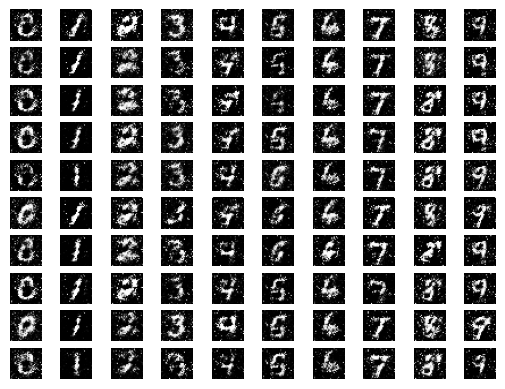

1/1 [==============================] - 0s 10ms/step
4001 [D loss: 1.0106282532215118, acc.: 30.430254340171814%] [G loss: 2.014254093170166]
1/1 [==============================] - 0s 9ms/step
4002 [D loss: 0.8839874267578125, acc.: 38.16337585449219%] [G loss: 1.9512593746185303]
1/1 [==============================] - 0s 10ms/step
4003 [D loss: 0.8285295367240906, acc.: 36.826398968696594%] [G loss: 1.889237880706787]
1/1 [==============================] - 0s 9ms/step
4004 [D loss: 1.012549877166748, acc.: 40.70975035429001%] [G loss: 1.6090799570083618]
1/1 [==============================] - 0s 10ms/step
4005 [D loss: 0.8095203340053558, acc.: 27.391770482063293%] [G loss: 1.686615228652954]
1/1 [==============================] - 0s 10ms/step
4006 [D loss: 0.9354404211044312, acc.: 31.37313425540924%] [G loss: 1.9060537815093994]
1/1 [==============================] - 0s 8ms/step
4007 [D loss: 1.1634995937347412, acc.: 22.980740666389465%] [G loss: 1.606353998184204]
1/1 [============

1/1 [==============================] - 0s 9ms/step
4060 [D loss: 0.7907663285732269, acc.: 26.050759851932526%] [G loss: 1.8492416143417358]
1/1 [==============================] - 0s 9ms/step
4061 [D loss: 0.8914554417133331, acc.: 36.21953725814819%] [G loss: 1.731292724609375]
1/1 [==============================] - 0s 9ms/step
4062 [D loss: 0.910921573638916, acc.: 36.84167265892029%] [G loss: 2.108891725540161]
1/1 [==============================] - 0s 10ms/step
4063 [D loss: 0.8830502033233643, acc.: 34.36674922704697%] [G loss: 1.8078505992889404]
1/1 [==============================] - 0s 8ms/step
4064 [D loss: 1.0563300848007202, acc.: 37.792590260505676%] [G loss: 1.823668360710144]
1/1 [==============================] - 0s 9ms/step
4065 [D loss: 0.9954961836338043, acc.: 31.048674881458282%] [G loss: 1.8283687829971313]
1/1 [==============================] - 0s 8ms/step
4066 [D loss: 1.0357354283332825, acc.: 33.70104432106018%] [G loss: 1.8093321323394775]
1/1 [===============

1/1 [==============================] - 0s 10ms/step
4119 [D loss: 0.9082627892494202, acc.: 33.30058455467224%] [G loss: 1.6656941175460815]
1/1 [==============================] - 0s 8ms/step
4120 [D loss: 0.8849929571151733, acc.: 27.574056386947632%] [G loss: 1.7171255350112915]
1/1 [==============================] - 0s 8ms/step
4121 [D loss: 0.8607461154460907, acc.: 32.92526751756668%] [G loss: 1.7988888025283813]
1/1 [==============================] - 0s 9ms/step
4122 [D loss: 0.9836393594741821, acc.: 34.55820828676224%] [G loss: 1.8201231956481934]
1/1 [==============================] - 0s 8ms/step
4123 [D loss: 0.8448824882507324, acc.: 31.58182054758072%] [G loss: 1.9606884717941284]
1/1 [==============================] - 0s 9ms/step
4124 [D loss: 0.9245538115501404, acc.: 37.52783685922623%] [G loss: 1.7727655172348022]
1/1 [==============================] - 0s 9ms/step
4125 [D loss: 0.8479970991611481, acc.: 37.68025487661362%] [G loss: 1.9037672281265259]
1/1 [=============

1/1 [==============================] - 0s 10ms/step
4178 [D loss: 0.8605694770812988, acc.: 29.38028872013092%] [G loss: 1.6998143196105957]
1/1 [==============================] - 0s 8ms/step
4179 [D loss: 1.0755487382411957, acc.: 29.36128079891205%] [G loss: 1.8565536737442017]
1/1 [==============================] - 0s 8ms/step
4180 [D loss: 0.8639282882213593, acc.: 36.931197345256805%] [G loss: 2.0315163135528564]
1/1 [==============================] - 0s 9ms/step
4181 [D loss: 0.905248612165451, acc.: 36.97496056556702%] [G loss: 2.0688719749450684]
1/1 [==============================] - 0s 8ms/step
4182 [D loss: 0.9978074431419373, acc.: 32.1528822183609%] [G loss: 1.9135075807571411]
1/1 [==============================] - 0s 9ms/step
4183 [D loss: 0.9647099077701569, acc.: 36.925119161605835%] [G loss: 1.9551169872283936]
1/1 [==============================] - 0s 10ms/step
4184 [D loss: 1.0751510560512543, acc.: 33.78573805093765%] [G loss: 2.573679208755493]
1/1 [==============

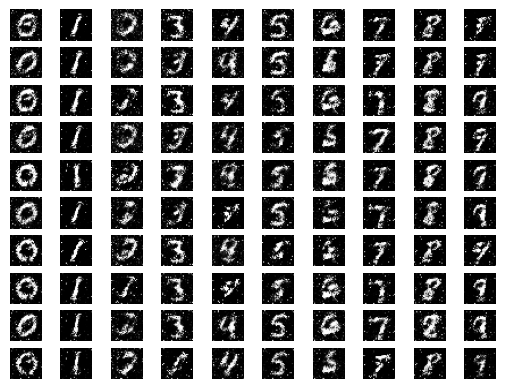

1/1 [==============================] - 0s 11ms/step
4201 [D loss: 1.0210343897342682, acc.: 32.11539536714554%] [G loss: 1.732706904411316]
1/1 [==============================] - 0s 10ms/step
4202 [D loss: 1.282580018043518, acc.: 33.520086109638214%] [G loss: 1.875415325164795]
1/1 [==============================] - 0s 8ms/step
4203 [D loss: 0.8853583037853241, acc.: 32.948945462703705%] [G loss: 1.8411916494369507]
1/1 [==============================] - 0s 8ms/step
4204 [D loss: 0.9388798177242279, acc.: 27.046704292297363%] [G loss: 1.7454720735549927]
1/1 [==============================] - 0s 9ms/step
4205 [D loss: 1.0608641803264618, acc.: 35.01079976558685%] [G loss: 1.7011806964874268]
1/1 [==============================] - 0s 9ms/step
4206 [D loss: 0.8543315529823303, acc.: 29.189851880073547%] [G loss: 2.0484018325805664]
1/1 [==============================] - 0s 8ms/step
4207 [D loss: 0.9954287111759186, acc.: 37.30528652667999%] [G loss: 1.6326322555541992]
1/1 [============

1/1 [==============================] - 0s 8ms/step
4260 [D loss: 0.9100960493087769, acc.: 30.56129962205887%] [G loss: 1.8391783237457275]
1/1 [==============================] - 0s 8ms/step
4261 [D loss: 0.7956896722316742, acc.: 30.45586496591568%] [G loss: 1.9044586420059204]
1/1 [==============================] - 0s 10ms/step
4262 [D loss: 0.8787674605846405, acc.: 39.8897647857666%] [G loss: 1.9361741542816162]
1/1 [==============================] - 0s 11ms/step
4263 [D loss: 0.9386868178844452, acc.: 35.926829278469086%] [G loss: 1.819346308708191]
1/1 [==============================] - 0s 10ms/step
4264 [D loss: 0.832713782787323, acc.: 30.95155358314514%] [G loss: 2.1368682384490967]
1/1 [==============================] - 0s 8ms/step
4265 [D loss: 0.8387175798416138, acc.: 35.89954823255539%] [G loss: 2.3222496509552]
1/1 [==============================] - 0s 8ms/step
4266 [D loss: 1.2362550795078278, acc.: 32.82710313796997%] [G loss: 1.7700417041778564]
1/1 [=================

1/1 [==============================] - 0s 8ms/step
4319 [D loss: 0.8261247277259827, acc.: 31.727267801761627%] [G loss: 2.200425863265991]
1/1 [==============================] - 0s 9ms/step
4320 [D loss: 1.0207838416099548, acc.: 32.23845809698105%] [G loss: 2.3676376342773438]
1/1 [==============================] - 0s 11ms/step
4321 [D loss: 0.9476313292980194, acc.: 30.44714629650116%] [G loss: 2.3114960193634033]
1/1 [==============================] - 0s 8ms/step
4322 [D loss: 0.8124128580093384, acc.: 26.800844073295593%] [G loss: 1.9129739999771118]
1/1 [==============================] - 0s 10ms/step
4323 [D loss: 1.4047170281410217, acc.: 33.007679879665375%] [G loss: 1.8258312940597534]
1/1 [==============================] - 0s 9ms/step
4324 [D loss: 0.7833869159221649, acc.: 29.97131198644638%] [G loss: 1.9274590015411377]
1/1 [==============================] - 0s 9ms/step
4325 [D loss: 0.927126407623291, acc.: 32.456204295158386%] [G loss: 2.106562852859497]
1/1 [============

1/1 [==============================] - 0s 9ms/step
4378 [D loss: 1.0217794179916382, acc.: 38.07942569255829%] [G loss: 1.7892558574676514]
1/1 [==============================] - 0s 9ms/step
4379 [D loss: 1.1446173787117004, acc.: 36.07051372528076%] [G loss: 1.9088188409805298]
1/1 [==============================] - 0s 10ms/step
4380 [D loss: 0.9197530448436737, acc.: 36.20050996541977%] [G loss: 2.204575300216675]
1/1 [==============================] - 0s 9ms/step
4381 [D loss: 1.1480545401573181, acc.: 40.42356610298157%] [G loss: 1.808855414390564]
1/1 [==============================] - 0s 9ms/step
4382 [D loss: 0.9689732193946838, acc.: 28.524288535118103%] [G loss: 2.318709373474121]
1/1 [==============================] - 0s 9ms/step
4383 [D loss: 0.977746844291687, acc.: 35.07839739322662%] [G loss: 1.8664720058441162]
1/1 [==============================] - 0s 8ms/step
4384 [D loss: 1.0436676144599915, acc.: 31.236204504966736%] [G loss: 1.8674845695495605]
1/1 [================

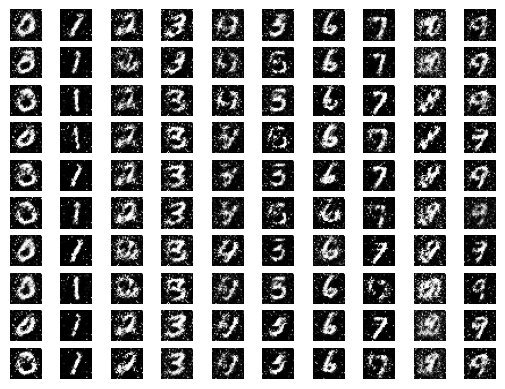

1/1 [==============================] - 0s 11ms/step
4401 [D loss: 0.9720805585384369, acc.: 38.18795084953308%] [G loss: 2.1396234035491943]
1/1 [==============================] - 0s 8ms/step
4402 [D loss: 0.9820159077644348, acc.: 34.22917574644089%] [G loss: 2.2047197818756104]
1/1 [==============================] - 0s 9ms/step
4403 [D loss: 1.0609523952007294, acc.: 31.861084699630737%] [G loss: 1.9228696823120117]
1/1 [==============================] - 0s 11ms/step
4404 [D loss: 0.9911526143550873, acc.: 36.3724410533905%] [G loss: 2.2061636447906494]
1/1 [==============================] - 0s 8ms/step
4405 [D loss: 0.9446362853050232, acc.: 30.252188444137573%] [G loss: 1.7557307481765747]
1/1 [==============================] - 0s 10ms/step
4406 [D loss: 0.9683628380298615, acc.: 27.581065893173218%] [G loss: 1.8887393474578857]
1/1 [==============================] - 0s 9ms/step
4407 [D loss: 1.164518654346466, acc.: 33.44500809907913%] [G loss: 1.9884109497070312]
1/1 [===========

1/1 [==============================] - 0s 9ms/step
4460 [D loss: 0.9668236076831818, acc.: 36.0478401184082%] [G loss: 1.9181647300720215]
1/1 [==============================] - 0s 8ms/step
4461 [D loss: 0.7593097984790802, acc.: 27.065828442573547%] [G loss: 1.9332290887832642]
1/1 [==============================] - 0s 11ms/step
4462 [D loss: 0.8651602268218994, acc.: 26.272132992744446%] [G loss: 2.107667922973633]
1/1 [==============================] - 0s 9ms/step
4463 [D loss: 1.2518351674079895, acc.: 34.581248462200165%] [G loss: 1.8269100189208984]
1/1 [==============================] - 0s 10ms/step
4464 [D loss: 0.9652230441570282, acc.: 32.73260295391083%] [G loss: 1.8425742387771606]
1/1 [==============================] - 0s 8ms/step
4465 [D loss: 1.0008836388587952, acc.: 30.91719150543213%] [G loss: 1.9453544616699219]
1/1 [==============================] - 0s 13ms/step
4466 [D loss: 0.8967010676860809, acc.: 35.84741801023483%] [G loss: 2.2276594638824463]
1/1 [===========

1/1 [==============================] - 0s 10ms/step
4519 [D loss: 0.8681195378303528, acc.: 34.78519767522812%] [G loss: 1.8801754713058472]
1/1 [==============================] - 0s 10ms/step
4520 [D loss: 0.7721845209598541, acc.: 27.19663679599762%] [G loss: 1.9546645879745483]
1/1 [==============================] - 0s 10ms/step
4521 [D loss: 1.0718139111995697, acc.: 42.683108150959015%] [G loss: 1.8846513032913208]
1/1 [==============================] - 0s 9ms/step
4522 [D loss: 0.9140825271606445, acc.: 30.448293685913086%] [G loss: 2.0554938316345215]
1/1 [==============================] - 0s 9ms/step
4523 [D loss: 1.1011038422584534, acc.: 35.60689985752106%] [G loss: 1.6152867078781128]
1/1 [==============================] - 0s 8ms/step
4524 [D loss: 0.9659712612628937, acc.: 36.191731691360474%] [G loss: 1.5443179607391357]
1/1 [==============================] - 0s 9ms/step
4525 [D loss: 0.9956571757793427, acc.: 31.13745152950287%] [G loss: 1.709244728088379]
1/1 [==========

1/1 [==============================] - 0s 9ms/step
4578 [D loss: 1.0016671419143677, acc.: 39.757974445819855%] [G loss: 1.7772917747497559]
1/1 [==============================] - 0s 11ms/step
4579 [D loss: 1.0144821107387543, acc.: 33.45365822315216%] [G loss: 1.85077965259552]
1/1 [==============================] - 0s 9ms/step
4580 [D loss: 0.8702640533447266, acc.: 27.21695452928543%] [G loss: 2.0676560401916504]
1/1 [==============================] - 0s 11ms/step
4581 [D loss: 1.0290511548519135, acc.: 41.41868352890015%] [G loss: 2.0393176078796387]
1/1 [==============================] - 0s 12ms/step
4582 [D loss: 0.7640011012554169, acc.: 24.436459690332413%] [G loss: 2.084705114364624]
1/1 [==============================] - 0s 10ms/step
4583 [D loss: 0.869076669216156, acc.: 25.674015283584595%] [G loss: 2.0905513763427734]
1/1 [==============================] - 0s 8ms/step
4584 [D loss: 0.8190518319606781, acc.: 40.75637012720108%] [G loss: 2.160121202468872]
1/1 [=============

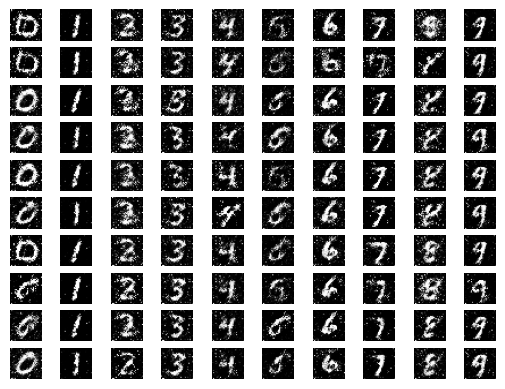

1/1 [==============================] - 0s 10ms/step
4601 [D loss: 1.0886275172233582, acc.: 39.11045342683792%] [G loss: 1.984933614730835]
1/1 [==============================] - 0s 8ms/step
4602 [D loss: 1.1532285511493683, acc.: 33.256080746650696%] [G loss: 1.8686537742614746]
1/1 [==============================] - 0s 10ms/step
4603 [D loss: 0.992692232131958, acc.: 33.420222997665405%] [G loss: 1.8904352188110352]
1/1 [==============================] - 0s 9ms/step
4604 [D loss: 0.9849227070808411, acc.: 29.74380850791931%] [G loss: 1.6445019245147705]
1/1 [==============================] - 0s 9ms/step
4605 [D loss: 0.8258576989173889, acc.: 27.503685653209686%] [G loss: 1.8924472332000732]
1/1 [==============================] - 0s 8ms/step
4606 [D loss: 0.8615127801895142, acc.: 24.098017066717148%] [G loss: 1.7630677223205566]
1/1 [==============================] - 0s 8ms/step
4607 [D loss: 0.8378703892230988, acc.: 31.326183676719666%] [G loss: 2.0168254375457764]
1/1 [==========

1/1 [==============================] - 0s 9ms/step
4660 [D loss: 0.9293287396430969, acc.: 35.656286776065826%] [G loss: 2.0160024166107178]
1/1 [==============================] - 0s 9ms/step
4661 [D loss: 0.9958285093307495, acc.: 34.70308780670166%] [G loss: 2.0415210723876953]
1/1 [==============================] - 0s 8ms/step
4662 [D loss: 0.7866648435592651, acc.: 24.10370334982872%] [G loss: 2.108424186706543]
1/1 [==============================] - 0s 8ms/step
4663 [D loss: 0.936313807964325, acc.: 25.957560539245605%] [G loss: 2.083367109298706]
1/1 [==============================] - 0s 10ms/step
4664 [D loss: 1.0030779242515564, acc.: 41.83907508850098%] [G loss: 2.0918986797332764]
1/1 [==============================] - 0s 9ms/step
4665 [D loss: 1.0007719993591309, acc.: 32.386013865470886%] [G loss: 1.986862301826477]
1/1 [==============================] - 0s 10ms/step
4666 [D loss: 1.0674618780612946, acc.: 38.375525176525116%] [G loss: 2.220137119293213]
1/1 [==============

1/1 [==============================] - 0s 11ms/step
4719 [D loss: 0.8382112085819244, acc.: 30.500589311122894%] [G loss: 2.3840296268463135]
1/1 [==============================] - 0s 9ms/step
4720 [D loss: 0.9386067986488342, acc.: 31.88455104827881%] [G loss: 2.3402111530303955]
1/1 [==============================] - 0s 10ms/step
4721 [D loss: 1.0750792026519775, acc.: 33.51927697658539%] [G loss: 2.310624837875366]
1/1 [==============================] - 0s 11ms/step
4722 [D loss: 0.7621980011463165, acc.: 36.14642024040222%] [G loss: 2.252000570297241]
1/1 [==============================] - 0s 8ms/step
4723 [D loss: 0.7762951850891113, acc.: 28.329968452453613%] [G loss: 2.346961736679077]
1/1 [==============================] - 0s 10ms/step
4724 [D loss: 1.0275766849517822, acc.: 28.024643659591675%] [G loss: 1.7222498655319214]
1/1 [==============================] - 0s 9ms/step
4725 [D loss: 1.1851599216461182, acc.: 31.784328818321228%] [G loss: 1.9037522077560425]
1/1 [==========

1/1 [==============================] - 0s 10ms/step
4778 [D loss: 0.9174982607364655, acc.: 34.19307619333267%] [G loss: 1.6547456979751587]
1/1 [==============================] - 0s 9ms/step
4779 [D loss: 1.1049210727214813, acc.: 29.288040101528168%] [G loss: 1.7507315874099731]
1/1 [==============================] - 0s 8ms/step
4780 [D loss: 0.9786834716796875, acc.: 33.35878103971481%] [G loss: 1.9537686109542847]
1/1 [==============================] - 0s 9ms/step
4781 [D loss: 0.9963656067848206, acc.: 25.672590732574463%] [G loss: 1.7123771905899048]
1/1 [==============================] - 0s 10ms/step
4782 [D loss: 0.9498124718666077, acc.: 36.19580715894699%] [G loss: 1.8052242994308472]
1/1 [==============================] - 0s 9ms/step
4783 [D loss: 1.0259629487991333, acc.: 36.48967742919922%] [G loss: 2.193251609802246]
1/1 [==============================] - 0s 8ms/step
4784 [D loss: 0.9914583563804626, acc.: 31.00886195898056%] [G loss: 1.9140621423721313]
1/1 [============

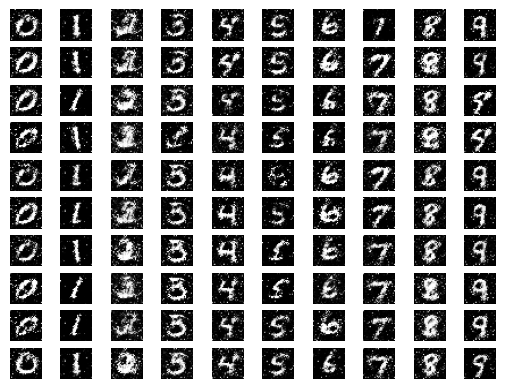

1/1 [==============================] - 0s 10ms/step
4801 [D loss: 0.9192362725734711, acc.: 31.462526321411133%] [G loss: 1.9495339393615723]
1/1 [==============================] - 0s 8ms/step
4802 [D loss: 1.067614197731018, acc.: 30.539114773273468%] [G loss: 1.8112822771072388]
1/1 [==============================] - 0s 8ms/step
4803 [D loss: 1.0942902565002441, acc.: 42.33797490596771%] [G loss: 1.9746332168579102]
1/1 [==============================] - 0s 11ms/step
4804 [D loss: 0.8743627369403839, acc.: 35.53864657878876%] [G loss: 1.9535841941833496]
1/1 [==============================] - 0s 9ms/step
4805 [D loss: 1.0192812383174896, acc.: 33.36128294467926%] [G loss: 1.8659687042236328]
1/1 [==============================] - 0s 9ms/step
4806 [D loss: 0.9754391014575958, acc.: 35.406407713890076%] [G loss: 1.7233721017837524]
1/1 [==============================] - 0s 8ms/step
4807 [D loss: 0.9819291234016418, acc.: 30.901922285556793%] [G loss: 1.7514493465423584]
1/1 [==========

4859 [D loss: 0.954875260591507, acc.: 35.10546535253525%] [G loss: 1.8476938009262085]
1/1 [==============================] - 0s 8ms/step
4860 [D loss: 0.8938237130641937, acc.: 35.548728704452515%] [G loss: 1.79957914352417]
1/1 [==============================] - 0s 8ms/step
4861 [D loss: 0.9801357090473175, acc.: 40.312591195106506%] [G loss: 1.7766910791397095]
1/1 [==============================] - 0s 8ms/step
4862 [D loss: 0.83332759141922, acc.: 34.50769484043121%] [G loss: 1.8300533294677734]
1/1 [==============================] - 0s 8ms/step
4863 [D loss: 0.8551600873470306, acc.: 37.24794238805771%] [G loss: 1.7091917991638184]
1/1 [==============================] - 0s 8ms/step
4864 [D loss: 1.0528481602668762, acc.: 40.13036787509918%] [G loss: 1.7962019443511963]
1/1 [==============================] - 0s 9ms/step
4865 [D loss: 1.0559966564178467, acc.: 40.49164950847626%] [G loss: 2.0172743797302246]
1/1 [==============================] - 0s 12ms/step
4866 [D loss: 0.835898

1/1 [==============================] - 0s 10ms/step
4918 [D loss: 0.755071222782135, acc.: 30.165350437164307%] [G loss: 1.7551349401474]
1/1 [==============================] - 0s 8ms/step
4919 [D loss: 0.9149898290634155, acc.: 27.535080909729004%] [G loss: 2.0443670749664307]
1/1 [==============================] - 0s 11ms/step
4920 [D loss: 0.7959370017051697, acc.: 31.3381165266037%] [G loss: 2.144667148590088]
1/1 [==============================] - 0s 10ms/step
4921 [D loss: 0.8978855907917023, acc.: 28.2416895031929%] [G loss: 2.014594554901123]
1/1 [==============================] - 0s 9ms/step
4922 [D loss: 0.9317077696323395, acc.: 31.874623894691467%] [G loss: 1.818803310394287]
1/1 [==============================] - 0s 11ms/step
4923 [D loss: 0.9518753588199615, acc.: 36.52264028787613%] [G loss: 2.0552890300750732]
1/1 [==============================] - 0s 8ms/step
4924 [D loss: 1.0206234157085419, acc.: 34.48478877544403%] [G loss: 1.9628926515579224]
1/1 [=================

4976 [D loss: 0.9369493424892426, acc.: 32.238344848155975%] [G loss: 1.9473097324371338]
1/1 [==============================] - 0s 10ms/step
4977 [D loss: 0.986087292432785, acc.: 42.26808845996857%] [G loss: 2.1937992572784424]
1/1 [==============================] - 0s 9ms/step
4978 [D loss: 0.7490981817245483, acc.: 28.94858866930008%] [G loss: 1.9759079217910767]
1/1 [==============================] - 0s 9ms/step
4979 [D loss: 0.9035001695156097, acc.: 28.802549839019775%] [G loss: 1.7073668241500854]
1/1 [==============================] - 0s 8ms/step
4980 [D loss: 0.8777934312820435, acc.: 35.787925124168396%] [G loss: 2.4777557849884033]
1/1 [==============================] - 0s 9ms/step
4981 [D loss: 1.0466215014457703, acc.: 36.93746328353882%] [G loss: 1.7522000074386597]
1/1 [==============================] - 0s 10ms/step
4982 [D loss: 0.8480367958545685, acc.: 31.757771968841553%] [G loss: 1.8504104614257812]
1/1 [==============================] - 0s 8ms/step
4983 [D loss: 0

In [60]:
train(epochs=5000, batch_size=32, sample_interval=200)

### Test the model

In [66]:
r, c = 10, 10
noise = np.random.normal(0, 1, (r * c, noise_dim))
sampled_labels = np.tile(np.arange(0, 10), r)
sampled_labels = tf.keras.utils.to_categorical(sampled_labels, num_classes)
sampled_con = np.random.uniform(-1, 1, (r * c, con_dim))

In [68]:
gen_imgs = generator.predict([noise, sampled_labels, sampled_con])

4/4 [==============================] - 0s 2ms/step


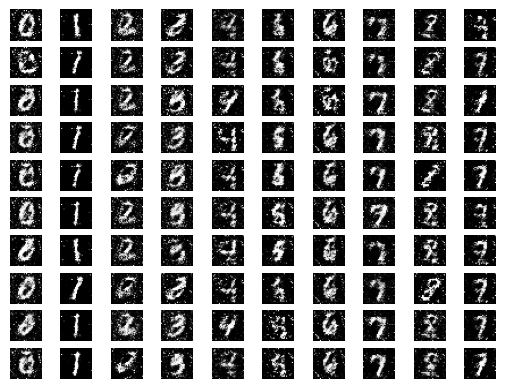

In [65]:
plt_imgs = 0.5 * gen_imgs + 0.5
fig, axs = plt.subplots(r, c)
cnt = 0
for i in range(r):
    for j in range(c):
        axs[i, j].imshow(plt_imgs[cnt, :, :, 0], cmap='gray')
        axs[i, j].axis('off')
        cnt += 1
plt.show()

In [73]:
fake = np.zeros((batch_size, 1))
d_loss_fake = discriminator(gen_imgs, [fake, sampled_labels.argmax(axis=1), sampled_con])

In [95]:
d_loss_fake[0][1]

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.31487104], dtype=float32)>

In [92]:
d_loss_fake[1][1]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([2.4242986e-08, 9.9925321e-01, 8.3363098e-05, 3.3681130e-04,
       3.5175537e-05, 4.0846269e-05, 1.8035207e-05, 1.8646950e-05,
       1.6695922e-04, 4.7036909e-05], dtype=float32)>

In [96]:
d_loss_fake[2][1]

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.00016533, 0.00026042], dtype=float32)>